# Capstone Project :  
Skincare Product Analysis - Decoding your Skincare Product
------------------------------------------------------------

### Notebook Organisation

**[Part 1](../code/1_data_cleaning.ipynb)**
1. **Data Cleaning** 

**[Part 2](../code/2_eda_preprocessing.ipynb)**

2. **Exploratory Data Analysis**  

**[Part 3](../code/3_data_cleaning_ingr.ipynb)**

3. **Data Cleaning of Ingredients**
4. **Exploratory Data Analysis of Ingredients**

**[Part 4](../code/4_recommender.ipynb)**

5. **Exploring Metrics for Recommendation System**
6. **Final Recommender System**

**<u>Part 5</u>** (Current notebook)

7. **Modelling**
8. **Insights**

# 7. Modelling

## 7.1. Data Import

We will first perform the standard importing of libraries and loading of datasets.

In [223]:
# Import libraries 
import numpy as np
import pandas as pd
import scipy.stats as stats

# Visual
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-processing
#!pip install nltk
import nltk
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
#!pip install regex
import re
#!pip install python-Levenshtein
#!pip install fuzzywuzzy
import fuzzywuzzy
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from itertools import chain

# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, roc_curve, auc,\
                            accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

# NLP
from nltk.corpus import stopwords
import string

# Bokeh
from bokeh.io import show, curdoc, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Select, Paragraph, TextInput
from bokeh.layouts import widgetbox, column, row
from ipywidgets import interact

# Similarity
from numpy import dot
from sklearn.manifold import TSNE

# Others
import time
import datetime as dt

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)

# Warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv('../data/sephora_clean_eda_ingr_clean.csv')

## 7.2. Model Preparation 

### Setup Variables and Target

In [3]:
# Check shape of df
df.shape

(1541, 164)

In [4]:
# Check columns
print(df.columns.tolist())

['id', 'name', 'value_price', 'url', 'details', 'ingredients', 'av_rating', 'sum_reviews', 'sum_love', 'product_name', 'skintype_sensitive', 'skintype_combination', 'skintype_normal', 'skintype_dry', 'skintype_oily', 'concerns_dryness', 'concerns_dullness', 'concerns_elasticity', 'concerns_darkspots', 'concerns_darkcircles', 'concerns_puffiness', 'concerns_pores', 'concerns_wrinkles', 'concerns_aging', 'concerns_redness', 'concerns_oiliness', 'concerns_acne', 'concerns_others', 'pref_vegan', 'pref_crueltyfree', 'pref_glutenfree', 'pref_antioxidant', 'pref_hydration', 'skincareacids_hyaluronicacid', 'skincareacids_salicylicacid', 'skincareacids_AHA', 'skincareacids_retinol', 'excluded_parabens', 'excluded_sulfates', 'excluded_formaldehydes', 'excluded_phthalates', 'excluded_silicones', 'formulation_cream', 'formulation_serum', 'formulation_liquid', 'formulation_gel', 'formulation_spray', 'formulation_balm', 'award_allure', 'clinical_results', 'size_ml', 'price_per_unit_vol', 'brand', 'b

In [5]:
# Set up variables
target_var = 'price_range'
excluded_features = ['id', 'name', 'value_price', 'url','details', 'ingredients', 'product_name', #'size_ml',
                     'price_per_unit_vol', 'brand', 'category', #'ingredients_list',
                     'price_range', #'sum_reviews', 'sum_love'
                    ] 

In [6]:
# Create feature matrix (X) and target (y)
X = df.drop(columns = excluded_features)
y = df[target_var]

In [7]:
# Check if the classes are balance
y.value_counts(normalize = True)

1    0.350422
3    0.333550
2    0.316029
Name: price_range, dtype: float64

In [8]:
# Perform Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42, 
                                                    test_size= 0.33,  # by default, test_size = 0.25
                                                    shuffle=True,    # shuffling df 
                                                    stratify=y      # stratifying applied to mitigate imbalanced classes
                                                   )      

In [9]:
# Check train and test data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1032, 153)
(509, 153)
(1032,)
(509,)


### Tokenize Ingredients List

Tokenization is the foremost step while modelling text data. Tokenization in simple words is the process of splitting a phrase, sentence, paragraph, one or multiple text documents into smaller units. Text can be tokenized at a variety of units including: characters, words, sentences, paragraphs, and n-grams.

In this section, we will create a customised function to break down the ingredients list into individual ingredient-terms (i.e. tokens), which can also be referred to as the corpus.

In [10]:
# Preview 'ingredients_list' column
df['ingredients_list'].head()

0    patented alguronic acid, active vegan collagen, skin, mimicking ceramides and mary thistle colla...
1    patented alguronic acid, multi, triple lipid complex, vitamin, caffeine, cucumber, aloe, raspber...
2    and hyaluronic acid, microalgae, plant collagen, persian silk tree extract, water, caprylic capr...
3    patented alguronic acid, active vegan collagen, microalgae oil collagen vegan, aqua water, eau, ...
4    and hyaluronic acid, microalgae, vitamin, plant collagen, water, glyceride, butelyene glycol, o,...
Name: ingredients_list, dtype: object

In [11]:
# Define custom tokenizer to return a list of ingredients by partitioning text based on commas 
def separate_ingr(text):
    new_text= re.split(', ', str(text))
    new_text= [i.strip() for i in new_text if i!=''] 
    #recreate the document from filtered tokens
    return new_text

### Setup Model Functions

Whenever any algorithm is applied to textual data, there is a need to convert the text to a numeric form for the machine learning models to ingest. Both **CountVectorizer** and **TfidVectorizer** are pre-processing techniques that can generate a numeric form from an input text.

**CountVectorizer** converts a collection of text documents (i.e. ingredients list) into a matrix of token counts (i.e. number of unique ingredient-terms). While CountVectorizer can be helpful in understanding the type of text by the frequency of words in it, its major disadvantages are:

- Its inability in identifying more important and less important words for analysis.
- It will just consider words that are abundant in a corpus as the most statistically significant word.
- It also doesn't identify the relationships between words such as linguistic similarity between words.

**TF-IDF** is an abbreviation for Term Frequency Inverse Document Frequency. This is a statistic that is based on the frequency of a word in the corpus but it also provides a numerical representation of how important a word is for statistical analysis. TF-IDF is based on the logic that words that are too abundant in a corpus and words that are too rare are both not statistically important for finding a pattern. The Logarithmic factor in TF-IDF mathematically penalizes the words that are too abundant or too rare in the corpus by giving them low TF-IDF scores. Higher value of TF-IDF signifies higher importance of the words in the corpus while lower values represent lower importance. In our case, TfidfVectorizer works by proportionally increasing the number of times an ingredient-term appears in a product but is counterbalanced by the number of products in which it is present. Hence, ingredient-terms that are commonly present in all the products are not given a very high weightage. However, an ingredient-term that is present too many times in a few of the products will be given a higher weightage. Even though TF-IDF can provide a good understanding about the importance of words but just like CountVectorizer, its disadvantage is:

- It fails to provide linguistic information about the words such as the real meaning of the words, similarity with other words etc.

In [12]:
# Source: https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket

We will setup a pipeline to test out both vectorization techniques. We will also attempt to run 7 different models first with the default hyperparamters before optimising them via hyperparameters tuning subsequently. The 7 models that will be tested includes:

   1) Multi-class Logistic Regression

   2) K-nearest Neighbors

   3) Random Forest Classifier

   4) Support Vector Machine

   5) Adaptive Boosting Classifier 

   6) Gradient Boosting Classifier

   7) Extreme Gradient Boosting Classifier

Feature scaling will also be employed by removing the mean and scaling to unit variance. Feature scaling is needed to bring every feature in the same footing without any upfront importance because the feature consists of higher ranging values.
Feature scaling is essential for certain machine learning algorithms such as distance based algorithms, curve based algorithms or matrix factorization, decomposition or dimensionality reduction or gradient descent based algorithms. 

Examples of models where feature scaling matters include, Logistic Regression, K-nearest Neighbors, Support Vector Machine, etc.

On the other hand, certain tree based algorithms which are insensitive towards feature scaling as they are rule based algorithms such as Random Forests or Gradient Boosted Decision Trees.

In our case, we will use **StandardScaler** which standardizes features by removing the mean and scaling to unit variance.

In [13]:
# Source: https://www.kaggle.com/getting-started/159643
# Source: https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

In [14]:
# Instantiate vectorizers
vectorizers = {'cvec': CountVectorizer(analyzer = separate_ingr),
               'tvec': TfidfVectorizer(analyzer = separate_ingr)}

In [15]:
# Instantiate models
models = {'lr': LogisticRegression(max_iter=1000, random_state=42, verbose =1),
          'knn': KNeighborsClassifier(),
          'rfc': RandomForestClassifier(random_state=42, verbose =1),
          'svc': SVC(random_state=42, verbose =1),
          'ada': AdaBoostClassifier(random_state=42),
          'gbc': GradientBoostingClassifier(random_state=42, verbose =1, 
                                            validation_fraction = 0.2, n_iter_no_change=5, tol=0.01),
          'xgb': XGBClassifier(objective = 'multi:softprob', eval_metric = 'mlogloss', random_state=42, verbosity =1)
          }                            

In [16]:
# Create list to store model results for default hyperparameters
initial_list = []

# Instantiate list to store tuning results
tuning_list = []

In [17]:
# Define numeric and text_features for columntransformer
numeric_features = list(X_train.drop(columns = ['ingredients_list']))
text_features = 'ingredients_list'

In [18]:
# Function to run model -- input vectorizer and model
def run_model(vec, mod, vec_params={}, mod_params={}, grid_search=False):
    
    # Collect results in a dict
    results = {}      
    
    # This pipeline is for default hyperparameters
    text_pipe = Pipeline([           
            (vec, vectorizers[vec])
            ])
    
    numeric_pipe = Pipeline([          
            ('ss', StandardScaler())
            ])
    
    # Combine the text_pipe and numeric pipe using columntransformer
    # Remainder = 'passthrough' to keep the columns which do not need any preprocessing
    col_transformer = ColumnTransformer(transformers = 
                             [('text', text_pipe, 'ingredients_list'),
                              ('numeric', numeric_pipe, numeric_features)], remainder = 'passthrough')   
    
    # Complete the pipeline for default hyperparameters by mounting the model
    pipe = Pipeline([          
            ('preprocessor', col_transformer),
            (mod, models[mod])
            ])   
    
    # This pipeline is for tuning of hyperparameters
    if grid_search:              
        gs = GridSearchCV(pipe, param_grid = {**vec_params, **mod_params}, cv=5, verbose=1, n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    results['model'] = mod
    results['vectorizer'] = vec
    results['cross_val_score'] = cross_val_score(pipe, X_train, y_train, cv=5).mean()
    results['train'] = pipe.score(X_train, y_train)
    results['test'] = pipe.score(X_test, y_test) 
    predictions = pipe.predict(X_test)
    
    # Multi_class = One-vs-rest; computes the AUC of each class against the rest
    #results['roc'] = roc_auc_score(y_test, predictions, multi_class='ovr')  
     
    # Micro: Calculate metrics globally by counting the total true positives, false negatives and false positives.
    # Macro: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
    # Weighted: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). 
    results['macro_avg_precision'] = precision_score(y_test, predictions, average = 'macro')
    results['weighted_avg_precision'] = precision_score(y_test, predictions, average = 'weighted')
    results['macro_avg_recall'] = recall_score(y_test, predictions, average = 'macro')
    results['weighted_avg_recall'] = recall_score(y_test, predictions, average = 'weighted')
    results['macro_avg_f1_score'] = f1_score(y_test, predictions, average = 'macro')
    results['weighted_avg_f1_score'] = f1_score(y_test, predictions, average = 'weighted')
        
    if grid_search:
        tuning_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        initial_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    #Plotting the confusion matrix
    print('### CONFUSION MATRIX ###')
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(cm,
                     index = ['cheap','average','expensive'], 
                     columns = ['cheap','average','expensive'])
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True, annot_kws={"size": 14}, cmap = 'Blues', fmt="d")
    plt.title('Confusion Matrix', fontsize = 14)
    plt.ylabel('Actual Values', fontsize = 14)
    plt.xlabel('Predicted Values', fontsize = 14)
    plt.show()
    
    print('### CLASSIFICATION REPORT ###')
    
    print(classification_report(y_test, predictions, target_names=['cheap','average','expensive']))
    
    return pipe

## 7.3. Baseline Model

A naive classifier model is one that does not use any sophistication in order to make a prediction, typically making a random or constant prediction. Such models are naive because they do not use any knowledge about the domain or any learning in order to make a prediction. The performance of the baseline classifier on a classification task provides a lower bound on the expected performance of all other models on the problem (i.e. a minimum score above which a model is considered to have skill on the dataset). It also provides a point of relative improvement for all models evaluated on the dataset. 

Some common choices of naive classifiers include:
- Predict a random class;
- Predict a randomly selected class from the training dataset; and
- Predict the majority class from the training dataset.

As not all naive classifiers are created equal, and some perform better than others, the best-performing naive classifier is used in our case - **Predict the majority class from the training dataset**.

The scikit-learn machine learning library provides an implementation of the majority class naive classification algorithm using the DummyClassifier class.  For any classification predictive modeling problem where a categorical value is predicted, the algorithm predicts the class value that has the most observations in the training dataset, as we have indicated the strategy to be 'most_frequent'. 

Consequently, the baseline model predicts '1 - Cheap' for all products as it is the majority class, and achieves an accuracy of 34.97%. We will evaluate the performance of the selected machine learning model by comparing the accuracy score of the predictions against this baseline model.

In [19]:
# Souce: https://machinelearningmastery.com/how-to-develop-and-evaluate-naive-classifier-strategies-using-probability/

In [20]:
# Initialize Estimator
# stratified: generates predictions by respecting  training set's class distribution.
dummy_clf = DummyClassifier(strategy='most_frequent')  
dummy_clf.fit(X_train,y_train)

# Check Baseline Model accuracy score on y_test
dummy_clf.score(X_test,y_test)

0.34970530451866405

In [21]:
# The baseline model predicts '1 - Cheap' for all products as it is the majority class
y_test.value_counts(normalize = True)

1    0.349705
3    0.333988
2    0.316306
Name: price_range, dtype: float64

## 7.4. Evaluation Metrics

As there is no class imbalance, the classification metric used to measure the performance of the models will be **accuracy** - a measure of the proportion of true predictions over all predictions ($\frac {TP + TN}{TP + TN + FP + FN}$). Ideally the model accuracy should be > 0.7 and minimally better than baseline accuracy as we are less concerned about minimizing the false negatives and false positives. It should also be able to generalise unseen data well with little signs of overfitting (low variance between 'train' and 'test' scores).

The following are descriptors of the other evaluation metrics for reference: 

**Cross Validation Score** : expected accuracy of the model on out-of-training data

**Precision** : the proportion of positive cases that were correctly identified. 

$\frac{TP}{TP+FP}$

**Recall** : the proportion of actual positive cases which were correctly identified. 

$\frac{TP}{TP+FN}$

**F1-score** : the harmonic mean of Precision and Recall. In practice, when we try to increase the precision of our model, the recall goes down, and vice-versa. The F1-score captures both the trends in a single value. 

$\frac{2 x Recall x Precision}{Recall + Precision}$
    
**Receiver Operating Characteristic-Area Under Curve (ROC-AUC)** : ROC is the probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting the true class.

As this is a 3-class classification problem, we have also computed the various metrics using different averaging strategies for reference. The descriptions of these averaging strategies are as follows below: 

**Micro-averaged**: True positivies, false positives and false negatives are computed globally. All samples equally contribute to the final averaged metric.

**Macro-averaged**: True positivies, false positives and false negatives are computed for each class and their unweighted mean is returned. All classes equally contribute to the final averaged metric (arithmetic mean of the per-class scores; equal weights are given to each class).

**Weighted-averaged**: Metrics are computed for each class and returns the mean weighted by the number of true instances in each class. Each classes’s contribution to the average is weighted by its size (weight the score of each class by the number of samples from that class).

In [22]:
# Source: https://www.mariakhalusova.com/posts/2019-04-17-ml-model-evaluation-metrics-p2/

## 7.5. Models (with default hyperparameters)

In this section, we will run all 7 models with their default hyperparameters.

### 1) Multi-class Logistic Regression (with default hyperparameters)

Multi-class logistic regression is a form of logistic regression used to predict a target variable have more than 2 classes. This is appropriate for our 3-class classification problem. Like binary logistic regression, multi-class regression uses maximum likelihood estimation to evaluate the probability of categorical membership.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


### METRICS ###


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


{'model': 'lr',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6763331926269875,
 'train': 1.0,
 'test': 0.7190569744597249,
 'macro_avg_precision': 0.7167432769965449,
 'weighted_avg_precision': 0.7195037462273778,
 'macro_avg_recall': 0.7156342752049526,
 'weighted_avg_recall': 0.7190569744597249,
 'macro_avg_f1_score': 0.7158785271243296,
 'weighted_avg_f1_score': 0.7189622160068331}

### CONFUSION MATRIX ###


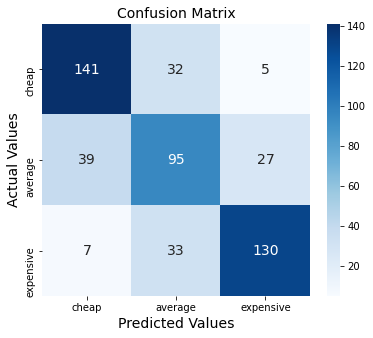

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.75      0.79      0.77       178
     average       0.59      0.59      0.59       161
   expensive       0.80      0.76      0.78       170

    accuracy                           0.72       509
   macro avg       0.72      0.72      0.72       509
weighted avg       0.72      0.72      0.72       509



In [23]:
cvec_lr = run_model('cvec', 'lr')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


### METRICS ###


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


{'model': 'lr',
 'vectorizer': 'tvec',
 'cross_val_score': 0.6841048731297781,
 'train': 0.9186046511627907,
 'test': 0.7485265225933202,
 'macro_avg_precision': 0.7446799976595608,
 'weighted_avg_precision': 0.7474672807856849,
 'macro_avg_recall': 0.7446913499156379,
 'weighted_avg_recall': 0.7485265225933202,
 'macro_avg_f1_score': 0.7442909981082826,
 'weighted_avg_f1_score': 0.7475916404461752}

### CONFUSION MATRIX ###


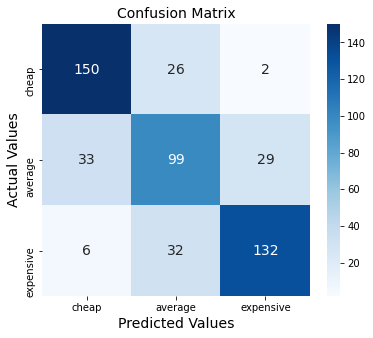

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.79      0.84      0.82       178
     average       0.63      0.61      0.62       161
   expensive       0.81      0.78      0.79       170

    accuracy                           0.75       509
   macro avg       0.74      0.74      0.74       509
weighted avg       0.75      0.75      0.75       509



In [24]:
tvec_lr = run_model('tvec', 'lr')

### 2) K-nearest Neighbors (with default hyperparameters)

### METRICS ###


{'model': 'knn',
 'vectorizer': 'cvec',
 'cross_val_score': 0.5591107358941889,
 'train': 0.752906976744186,
 'test': 0.6326129666011788,
 'macro_avg_precision': 0.6305199997458679,
 'weighted_avg_precision': 0.6324515003239034,
 'macro_avg_recall': 0.6258286020807932,
 'weighted_avg_recall': 0.6326129666011788,
 'macro_avg_f1_score': 0.6205291848361183,
 'weighted_avg_f1_score': 0.6247630658220972}

### CONFUSION MATRIX ###


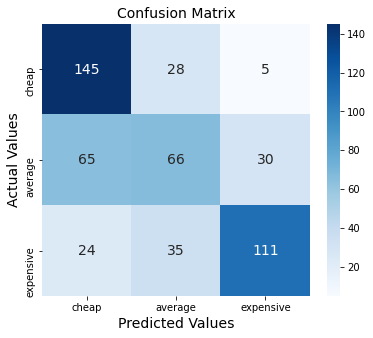

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.62      0.81      0.70       178
     average       0.51      0.41      0.46       161
   expensive       0.76      0.65      0.70       170

    accuracy                           0.63       509
   macro avg       0.63      0.63      0.62       509
weighted avg       0.63      0.63      0.62       509



In [25]:
cvec_knn = run_model('cvec', 'knn')

### METRICS ###


{'model': 'knn',
 'vectorizer': 'tvec',
 'cross_val_score': 0.568772571642981,
 'train': 0.7441860465116279,
 'test': 0.6444007858546169,
 'macro_avg_precision': 0.639467500487589,
 'weighted_avg_precision': 0.6427560800928402,
 'macro_avg_recall': 0.6396136177968988,
 'weighted_avg_recall': 0.6444007858546169,
 'macro_avg_f1_score': 0.6384896837378546,
 'weighted_avg_f1_score': 0.6424990846069856}

### CONFUSION MATRIX ###


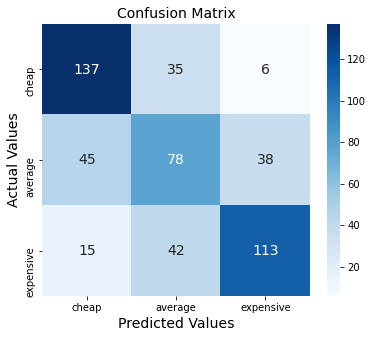

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.70      0.77      0.73       178
     average       0.50      0.48      0.49       161
   expensive       0.72      0.66      0.69       170

    accuracy                           0.64       509
   macro avg       0.64      0.64      0.64       509
weighted avg       0.64      0.64      0.64       509



In [26]:
tvec_knn = run_model('tvec', 'knn')

### 3) Random Forest Classifier (with default hyperparameters)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

### METRICS ###


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


{'model': 'rfc',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6200975563997936,
 'train': 1.0,
 'test': 0.6542239685658153,
 'macro_avg_precision': 0.6524634780012043,
 'weighted_avg_precision': 0.6526568594387123,
 'macro_avg_recall': 0.6468040269356399,
 'weighted_avg_recall': 0.6542239685658153,
 'macro_avg_f1_score': 0.6362216526858314,
 'weighted_avg_f1_score': 0.6402600617102139}

### CONFUSION MATRIX ###


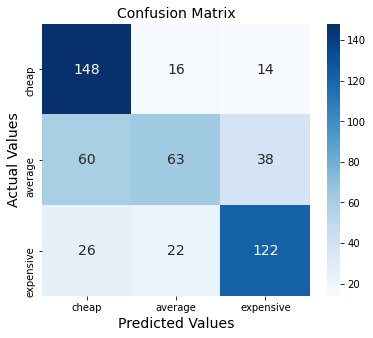

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.63      0.83      0.72       178
     average       0.62      0.39      0.48       161
   expensive       0.70      0.72      0.71       170

    accuracy                           0.65       509
   macro avg       0.65      0.65      0.64       509
weighted avg       0.65      0.65      0.64       509



In [27]:
cvec_rfc = run_model('cvec', 'rfc')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

### METRICS ###


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


{'model': 'rfc',
 'vectorizer': 'tvec',
 'cross_val_score': 0.6190750902865718,
 'train': 1.0,
 'test': 0.6542239685658153,
 'macro_avg_precision': 0.6522576434287046,
 'weighted_avg_precision': 0.6527082730703774,
 'macro_avg_recall': 0.6461871509717713,
 'weighted_avg_recall': 0.6542239685658153,
 'macro_avg_f1_score': 0.6348803226693938,
 'weighted_avg_f1_score': 0.6392343561240099}

### CONFUSION MATRIX ###


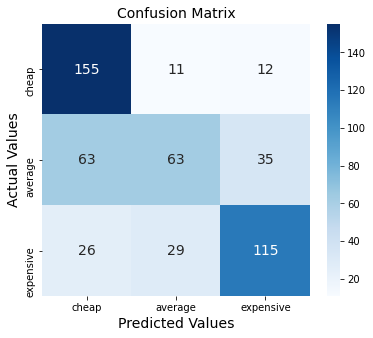

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.64      0.87      0.73       178
     average       0.61      0.39      0.48       161
   expensive       0.71      0.68      0.69       170

    accuracy                           0.65       509
   macro avg       0.65      0.65      0.63       509
weighted avg       0.65      0.65      0.64       509



In [28]:
tvec_rfc = run_model('tvec', 'rfc')

### 4) Support Vector Machine (with default hyperparameters)

The main objective in SVM is to find the optimal hyperplane to correctly classify between data points of different classes. The hyperplane dimensionality is equal to the number of input features minus one (eg. when working with three feature the hyperplane will be a two-dimensional plane).

Data points on one side of the hyperplane will be classified to a certain class while data points on the other side of the hyperplane will be classified to a different class. The distance between the hyperplane and the first point (for all the different classes) on either side of the hyperplane is a measure of how sure the algorithm is about its classification decision. The bigger the distance and the more confident we can be that SVM is making the right decision.

The data points closest to the hyperplane are called Support Vectors. Support Vectors determines the orientation and position of the hyperplane, in order to maximise the classifier margin (and therefore the classification score). 

The are two main types of classification SVM algorithms Hard Margin and Soft Margin:

- Hard Margin: aims to find the best hyperplane without tolerating any form of misclassification.
- Soft Margin: we add a degree of tolerance in SVM. In this way we allow the model to voluntary misclassify a few data points if that can lead to identifying a hyperplane able to generalise better to unseen data. Soft Margin SVM can be implemented in Scikit-Learn by adding a C penalty term. The bigger the C, the more penalty the algorithm gets when making a misclassification.

Weights are only assigned to linear SVM because the resulting separating plane is in the same space as the input features. Therefore its coefficients can be viewed as weights of the input's 'dimensions'. However, in other kernels, the separating plane exists in another space - a result of kernel transformation of the original space. In fact, the transformed space for the RBF kernel is infinite-dimensional, hence its coefficients are not directly related to the input space. 

In [29]:
# Source: https://towardsdatascience.com/svm-feature-selection-and-kernels-840781cc1a6c

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]### METRICS ###


{'model': 'svc',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6870128042774729,
 'train': 0.9302325581395349,
 'test': 0.7544204322200393,
 'macro_avg_precision': 0.7539340369529048,
 'weighted_avg_precision': 0.7564598313903278,
 'macro_avg_recall': 0.7516934668347065,
 'weighted_avg_recall': 0.7544204322200393,
 'macro_avg_f1_score': 0.7523820243023764,
 'weighted_avg_f1_score': 0.7550045842161192}

### CONFUSION MATRIX ###


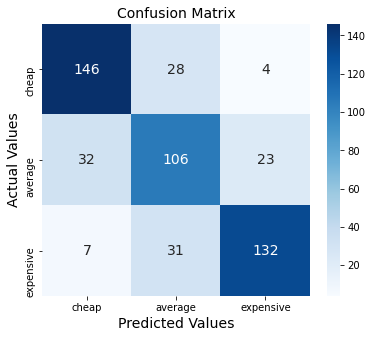

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.79      0.82      0.80       178
     average       0.64      0.66      0.65       161
   expensive       0.83      0.78      0.80       170

    accuracy                           0.75       509
   macro avg       0.75      0.75      0.75       509
weighted avg       0.76      0.75      0.76       509



In [30]:
cvec_svc = run_model('cvec', 'svc')

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]### METRICS ###


{'model': 'svc',
 'vectorizer': 'tvec',
 'cross_val_score': 0.679255194409268,
 'train': 0.8788759689922481,
 'test': 0.7367387033398821,
 'macro_avg_precision': 0.7388722859877822,
 'weighted_avg_precision': 0.7420023298325434,
 'macro_avg_recall': 0.7344870336996547,
 'weighted_avg_recall': 0.7367387033398821,
 'macro_avg_f1_score': 0.7359484233643999,
 'weighted_avg_f1_score': 0.7386547194095671}

### CONFUSION MATRIX ###


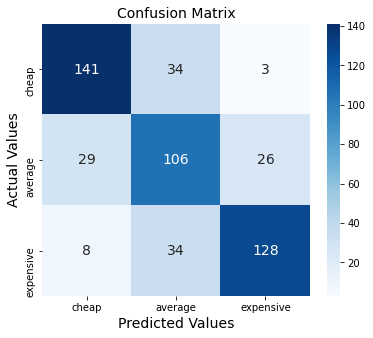

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.79      0.79      0.79       178
     average       0.61      0.66      0.63       161
   expensive       0.82      0.75      0.78       170

    accuracy                           0.74       509
   macro avg       0.74      0.73      0.74       509
weighted avg       0.74      0.74      0.74       509



In [31]:
tvec_svc = run_model('tvec', 'svc')

### 5) Adaptive Boosting Classifier (with default hyperparameters)

### METRICS ###


{'model': 'ada',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6346465925613245,
 'train': 0.6947674418604651,
 'test': 0.6895874263261297,
 'macro_avg_precision': 0.6859385783298827,
 'weighted_avg_precision': 0.689451772850594,
 'macro_avg_recall': 0.6859388406070782,
 'weighted_avg_recall': 0.6895874263261297,
 'macro_avg_f1_score': 0.6859221942460297,
 'weighted_avg_f1_score': 0.6895026737332361}

### CONFUSION MATRIX ###


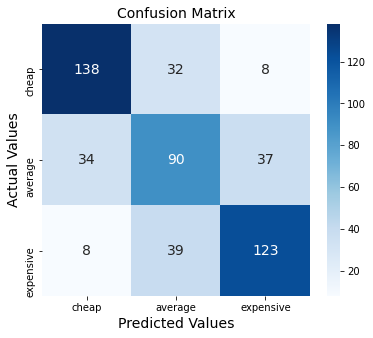

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.77      0.78      0.77       178
     average       0.56      0.56      0.56       161
   expensive       0.73      0.72      0.73       170

    accuracy                           0.69       509
   macro avg       0.69      0.69      0.69       509
weighted avg       0.69      0.69      0.69       509



In [32]:
cvec_ada = run_model('cvec', 'ada')

### METRICS ###


{'model': 'ada',
 'vectorizer': 'tvec',
 'cross_val_score': 0.6152384972562261,
 'train': 0.6782945736434108,
 'test': 0.6168958742632613,
 'macro_avg_precision': 0.6326341908058479,
 'weighted_avg_precision': 0.637965707690111,
 'macro_avg_recall': 0.6147761498346285,
 'weighted_avg_recall': 0.6168958742632613,
 'macro_avg_f1_score': 0.619188777540523,
 'weighted_avg_f1_score': 0.6230098205033678}

### CONFUSION MATRIX ###


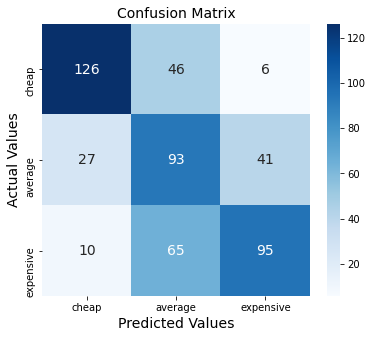

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.77      0.71      0.74       178
     average       0.46      0.58      0.51       161
   expensive       0.67      0.56      0.61       170

    accuracy                           0.62       509
   macro avg       0.63      0.61      0.62       509
weighted avg       0.64      0.62      0.62       509



In [33]:
tvec_ada = run_model('tvec', 'ada')

### 6) Gradient Boosting Classifier (with default hyperparameters)

Gradient Boosting Machine (for Regression and Classification) is a forward learning ensemble method. The guiding heuristic is that good predictive results can be obtained through increasingly refined approximations. Gradient Boosting Classifier sequentially builds trees on all the features of the dataset in a fully distributed way - each tree is built in parallel.

In [34]:
# Source: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html

      Iter       Train Loss   Remaining Time 
         1           1.0603            4.71s
         2           1.0263            4.63s
         3           0.9959            5.09s
         4           0.9691            4.92s
         5           0.9445            5.12s
         6           0.9216            5.04s
         7           0.9017            5.05s
         8           0.8823            4.91s
         9           0.8654            4.81s
        10           0.8479            5.22s
        20           0.7309            4.04s
        30           0.6511            3.46s
      Iter       Train Loss   Remaining Time 
         1           1.0570            3.09s
         2           1.0223            3.12s
         3           0.9934            3.12s
         4           0.9656            3.32s
         5           0.9410            3.24s
         6           0.9190            3.40s
         7           0.8983            3.30s
         8           0.8766            3.22s
        

{'model': 'gbc',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6162515829463908,
 'train': 0.8081395348837209,
 'test': 0.6601178781925344,
 'macro_avg_precision': 0.6450524946801671,
 'weighted_avg_precision': 0.6478366223930926,
 'macro_avg_recall': 0.653103332197559,
 'weighted_avg_recall': 0.6601178781925344,
 'macro_avg_f1_score': 0.6441920569580145,
 'weighted_avg_f1_score': 0.6491832495092955}

### CONFUSION MATRIX ###


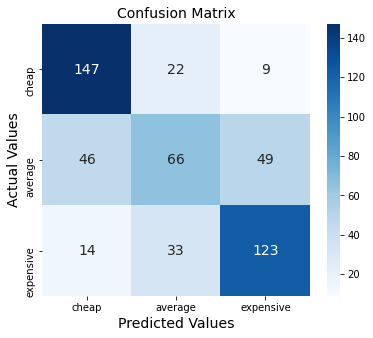

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.71      0.83      0.76       178
     average       0.55      0.41      0.47       161
   expensive       0.68      0.72      0.70       170

    accuracy                           0.66       509
   macro avg       0.65      0.65      0.64       509
weighted avg       0.65      0.66      0.65       509



In [35]:
cvec_gbc = run_model('cvec', 'gbc')

      Iter       Train Loss   Remaining Time 
         1           1.0579            6.27s
         2           1.0223            5.83s
         3           0.9917            5.91s
         4           0.9643            5.96s
         5           0.9393            5.64s
         6           0.9145            5.87s
         7           0.8932            6.08s
         8           0.8729            6.04s
         9           0.8523            5.79s
        10           0.8346            5.77s
        20           0.7116            5.14s
        30           0.6274            4.50s
      Iter       Train Loss   Remaining Time 
         1           1.0550            4.12s
         2           1.0199            5.29s
         3           0.9888            5.09s
         4           0.9603            4.29s
         5           0.9364            4.31s
         6           0.9152            4.53s
         7           0.8927            4.52s
         8           0.8709            4.32s
        

{'model': 'gbc',
 'vectorizer': 'tvec',
 'cross_val_score': 0.6210965714553727,
 'train': 0.8158914728682171,
 'test': 0.6208251473477406,
 'macro_avg_precision': 0.6023502103583346,
 'weighted_avg_precision': 0.6052490444497711,
 'macro_avg_recall': 0.6132321810013698,
 'weighted_avg_recall': 0.6208251473477406,
 'macro_avg_f1_score': 0.601219025292745,
 'weighted_avg_f1_score': 0.6065886296080376}

### CONFUSION MATRIX ###


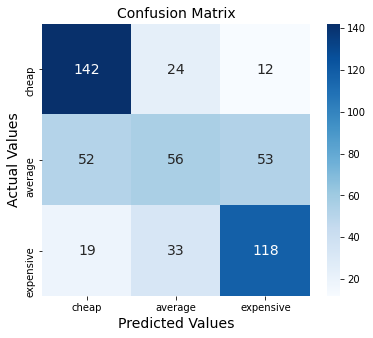

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.67      0.80      0.73       178
     average       0.50      0.35      0.41       161
   expensive       0.64      0.69      0.67       170

    accuracy                           0.62       509
   macro avg       0.60      0.61      0.60       509
weighted avg       0.61      0.62      0.61       509



In [36]:
tvec_gbc = run_model('tvec', 'gbc')

### 7) Extreme Gradient Boosting Classifier (with default hyperparameters)

### METRICS ###


{'model': 'xgb',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6695558369682473,
 'train': 1.0,
 'test': 0.693516699410609,
 'macro_avg_precision': 0.6875709714370449,
 'weighted_avg_precision': 0.6903509729524575,
 'macro_avg_recall': 0.6894864247604269,
 'weighted_avg_recall': 0.693516699410609,
 'macro_avg_f1_score': 0.6881743949574263,
 'weighted_avg_f1_score': 0.6915818231070339}

### CONFUSION MATRIX ###


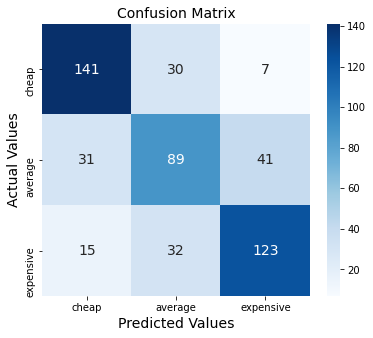

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.75      0.79      0.77       178
     average       0.59      0.55      0.57       161
   expensive       0.72      0.72      0.72       170

    accuracy                           0.69       509
   macro avg       0.69      0.69      0.69       509
weighted avg       0.69      0.69      0.69       509



In [37]:
cvec_xgb = run_model('cvec', 'xgb')

### METRICS ###


{'model': 'xgb',
 'vectorizer': 'tvec',
 'cross_val_score': 0.6540030955396088,
 'train': 1.0,
 'test': 0.650294695481336,
 'macro_avg_precision': 0.6501980280711934,
 'weighted_avg_precision': 0.6531273729383603,
 'macro_avg_recall': 0.6474066715108124,
 'weighted_avg_recall': 0.650294695481336,
 'macro_avg_f1_score': 0.648290705147282,
 'weighted_avg_f1_score': 0.6511996388444464}

### CONFUSION MATRIX ###


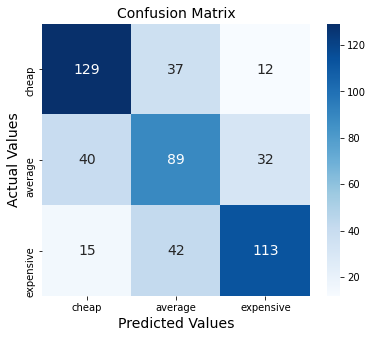

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.70      0.72      0.71       178
     average       0.53      0.55      0.54       161
   expensive       0.72      0.66      0.69       170

    accuracy                           0.65       509
   macro avg       0.65      0.65      0.65       509
weighted avg       0.65      0.65      0.65       509



In [38]:
tvec_xgb = run_model('tvec', 'xgb')

## 7.6. Models (with default hyperparameters)

In [39]:
# Create a dataframe to store evaluation scores
initial_df = pd.DataFrame(initial_list)

In [40]:
# Create a new column to reflect ('train > test') scores
# Positive ('train > test') scores = Overfitting
# Negative ('train > test') scores = Underfitting 
initial_df['train > test'] = initial_df['train'] - initial_df['test'] 

In [41]:
# Evaluation scores of the models ranked by 'test' scores
initial_df.sort_values(by='test', ascending = False).reset_index(drop=True)

,model,vectorizer,cross_val_score,train,test,macro_avg_precision,weighted_avg_precision,macro_avg_recall,weighted_avg_recall,macro_avg_f1_score,weighted_avg_f1_score,train > test
0,svc,cvec,0.687013,0.930233,0.754420,0.753934,0.756460,0.751693,0.754420,0.752382,0.755005,0.175812
1,lr,tvec,0.684105,0.918605,0.748527,0.744680,0.747467,0.744691,0.748527,0.744291,0.747592,0.170078
2,svc,tvec,0.679255,0.878876,0.736739,0.738872,0.742002,0.734487,0.736739,0.735948,0.738655,0.142137
3,lr,cvec,0.676333,1.000000,0.719057,0.716743,0.719504,0.715634,0.719057,0.715879,0.718962,0.280943
4,xgb,cvec,0.669556,1.000000,0.693517,0.687571,0.690351,0.689486,0.693517,0.688174,0.691582,0.306483
5,ada,cvec,0.634647,0.694767,0.689587,0.685939,0.689452,0.685939,0.689587,0.685922,0.689503,0.005180
6,gbc,cvec,0.616252,0.808140,0.660118,0.645052,0.647837,0.653103,0.660118,0.644192,0.649183,0.148022
7,rfc,cvec,0.620098,1.000000,0.654224,0.652463,0.652657,0.646804,0.654224,0.636222,0.640260,0.345776
8,rfc,tvec,0.619075,1.000000,0.654224,0.652258,0.652708,0.646187,0.654224,0.634880,0.639234,0.345776
9,xgb,tvec,0.654003,1.000000,0.650295,0.650198,0.653127,0.647407,0.650295,0.648291,0.651200,0.349705


## 7.7. Parameters

This section sets out the parameters that we will be working with in the models.

### Vectorizer Parameters

In [42]:
# CountVectorizer Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# https://stackoverflow.com/questions/63467815/how-to-access-columntransformer-elements-in-gridsearchcv

cvec_params = {
    # Setting a limit of n-number of features included/vocab size
    'preprocessor__text__cvec__max_features': [None, 500],

    # Setting a minimum number of times the word/token has to appear in n-documents. 
    # Ignore terms that appear in more than 50% of the documents, min_df =0.5
    'preprocessor__text__cvec__min_df':[1, 2, 3],
    
    # Setting an upper threshold/max percentage of n% of documents from corpus, default = 1.0. 
    # Removing terms that appear too frequently. 
    #'preprocessor__text__cvec__max_df': [0.2, 0.3, 0.4],
    
    # With stopwords
    'preprocessor__text__cvec__stop_words': ['english'],
}

In [43]:
# TfidfVectorizer Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

tvec_params = {
    'preprocessor__text__tvec__max_features': [None, 500],
    'preprocessor__text__tvec__min_df':[1, 2, 3],
    #'preprocessor__text__tvec__max_df': [0.2, 0.3, 0.4],
    'preprocessor__text__tvec__stop_words': ['english'],
}

### Model Parameters

In [44]:
# Logistic Regression Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

lr_params = {
    # Trying different types of regularization
    # l1 is used by lasso regression (zerorize coefficients), l2 is used by ridge regression 
    'lr__penalty':['l2','l1'],

     # Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.
    'lr__C':[0.1, 1, 10],
    
    # Solver supporting l1 and l2
    'lr__solver':['liblinear', 'saga', 'lbfgs']
}

In [45]:
# KNeighbors Classifer Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

knn_params = {
    # Number of neighbors to use by default for kneighbors queries
    'knn__n_neighbors':[3, 5],

    # Trying different weights
    'knn__weights': ['uniform', 'distance']
}

In [46]:
# Random Forest Classifier Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

rfc_params = {
    # Min number of samples required to be at a leaf node, default = 1. Increasing this lowers overfitting risk.
    'rfc__min_samples_leaf': [10, 15, 20],
    
    # Number of trees in the forest, default = 50, The more trees, the less likely the algorithm is to overfit.
    'rfc__n_estimators': [500, 1000],
    
    # The lower the number of features, the lesser the complexity and lesser the risk of overfitting.
    'rfc__max_features': [0.1, 0.2]
}

In [47]:
# Support Vector Machine Classifier Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

svc_params = {
    # The lower the gamma, the lower the risk of overfitting. For non-linear models.
    'svc__gamma': [0.001, 0.1],
    
    # Trying different kernels
    'svc__kernel': ['linear', 'rbf'],
    
    # Regularization parameter.
    # While setting a high value for C is likely to lead to a better model performance on the training data, \
    # there is a high risk of overfitting the model, producing poor results on the test data
    'svc__C': [0.001, 0.1, 1]
}

In [48]:
# AdaBoost Classifier Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
# https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f

ada_params = {
    # Maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning is stopped early.
    'ada__n_estimators': [500, 1000],
    
    # Weight applied to each classifier at each boosting iteration. Lower values preferred as it will make model robust.
    'ada__learning_rate': [0.001, 0.1]
}

In [49]:
# Gradient Boosting Classifier Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

gbc_params = {
    # Max depth that you allow the tree to grow to. Decreasing this reduces overfitting.
    'gbc__max_depth':[1, 3, 5],

    # Number of trees in the forest, default = 50, The more trees, the less likely the algorithm is to overfit.
    'gbc__n_estimators': [500, 1000]
}

In [50]:
# eXtreme Gradient Boosting Classifier Parameters
# https://xgboost.readthedocs.io/en/stable/parameter.html
# https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

xgb_params = {
    # Max depth that you allow the tree to grow to. Decreasing this reduces overfitting.
    'xgb__max_depth':[1, 3, 5],

    # A node is split only when the resulting split gives a positive reduction in the loss function. 
    # Gamma specifies the minimum loss reduction required to make a split.The lower the gamma, the lower the risk of overfitting.
    'xgb__gamma': [0, 0.1],
    
    # Maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning is stopped early.
    'xgb__n_estimators': [50, 500, 1000],
    
     # Weight applied to each classifier at each boosting iteration. Lower values preferred as it will make model robust.
    'xgb__eta': [0.001, 0.1]
}

## 7.8. Hyperparameter Tuning

Although the metrics for the models seemed rather optimistic, we will still attempt to optimise them so as to push the limits of the models further.

In [51]:
# Instantiate list to store tuning results
tuning_list = []

### 1) Multi-class Logistic Regression (with Grid Search hyperparameters)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LibLinear]Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LibLinear]Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LibLinear]Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LibLinear]Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 155 epochs took 0 seconds
### BEST PARAMS ###


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


{'lr__C': 0.1,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear',
 'preprocessor__text__cvec__max_features': None,
 'preprocessor__text__cvec__min_df': 1,
 'preprocessor__text__cvec__stop_words': 'english'}

### METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6782796304113315,
 'train': 0.9447674418604651,
 'test': 0.7347740667976425,
 'macro_avg_precision': 0.7282406370536268,
 'weighted_avg_precision': 0.731116000090935,
 'macro_avg_recall': 0.7304629717055361,
 'weighted_avg_recall': 0.7347740667976425,
 'macro_avg_f1_score': 0.7289024720707373,
 'weighted_avg_f1_score': 0.7324984900232399}

### CONFUSION MATRIX ###


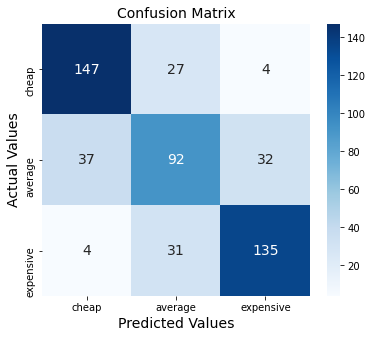

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.78      0.83      0.80       178
     average       0.61      0.57      0.59       161
   expensive       0.79      0.79      0.79       170

    accuracy                           0.73       509
   macro avg       0.73      0.73      0.73       509
weighted avg       0.73      0.73      0.73       509



In [52]:
cvec_lr_gs = run_model('cvec', 'lr', vec_params=cvec_params, mod_params=lr_params, grid_search=True)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LibLinear]Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


### BEST PARAMS ###


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


{'lr__C': 10,
 'lr__penalty': 'l2',
 'lr__solver': 'saga',
 'preprocessor__text__tvec__max_features': None,
 'preprocessor__text__tvec__min_df': 1,
 'preprocessor__text__tvec__stop_words': 'english'}

### METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'cross_val_score': 0.6831199287087848,
 'train': 0.9622093023255814,
 'test': 0.7445972495088409,
 'macro_avg_precision': 0.7403321489342994,
 'weighted_avg_precision': 0.7430288568890508,
 'macro_avg_recall': 0.7407268134415466,
 'weighted_avg_recall': 0.7445972495088409,
 'macro_avg_f1_score': 0.7401545200565653,
 'weighted_avg_f1_score': 0.7434298720028417}

### CONFUSION MATRIX ###


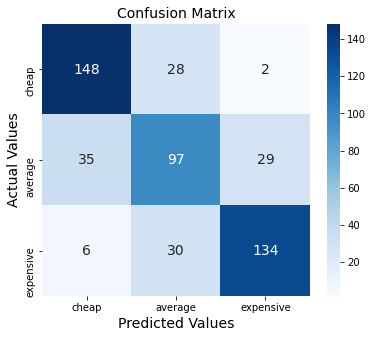

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.78      0.83      0.81       178
     average       0.63      0.60      0.61       161
   expensive       0.81      0.79      0.80       170

    accuracy                           0.74       509
   macro avg       0.74      0.74      0.74       509
weighted avg       0.74      0.74      0.74       509



In [53]:
tvec_lr_gs = run_model('tvec', 'lr', vec_params=tvec_params, mod_params=lr_params, grid_search=True)

### 2) K-nearest Neighbors (with Grid Search hyperparameters)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
### BEST PARAMS ###


{'knn__n_neighbors': 3,
 'knn__weights': 'distance',
 'preprocessor__text__cvec__max_features': None,
 'preprocessor__text__cvec__min_df': 1,
 'preprocessor__text__cvec__stop_words': 'english'}

### METRICS ###


{'model': 'knn',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6172365273673842,
 'train': 1.0,
 'test': 0.6817288801571709,
 'macro_avg_precision': 0.6758352682957879,
 'weighted_avg_precision': 0.6785686225099256,
 'macro_avg_recall': 0.6776572671081134,
 'weighted_avg_recall': 0.6817288801571709,
 'macro_avg_f1_score': 0.6763297882754853,
 'weighted_avg_f1_score': 0.6797308493768192}

### CONFUSION MATRIX ###


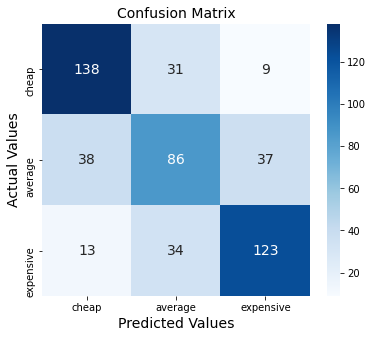

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.73      0.78      0.75       178
     average       0.57      0.53      0.55       161
   expensive       0.73      0.72      0.73       170

    accuracy                           0.68       509
   macro avg       0.68      0.68      0.68       509
weighted avg       0.68      0.68      0.68       509



In [54]:
cvec_knn_gs = run_model('cvec', 'knn', vec_params=cvec_params, mod_params=knn_params, grid_search=True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
### BEST PARAMS ###


{'knn__n_neighbors': 5,
 'knn__weights': 'distance',
 'preprocessor__text__tvec__max_features': None,
 'preprocessor__text__tvec__min_df': 1,
 'preprocessor__text__tvec__stop_words': 'english'}

### METRICS ###


{'model': 'knn',
 'vectorizer': 'tvec',
 'cross_val_score': 0.5949580226068196,
 'train': 1.0,
 'test': 0.6620825147347741,
 'macro_avg_precision': 0.6579798409959308,
 'weighted_avg_precision': 0.6615918009831386,
 'macro_avg_recall': 0.6586233320880868,
 'weighted_avg_recall': 0.6620825147347741,
 'macro_avg_f1_score': 0.6581107270762443,
 'weighted_avg_f1_score': 0.6616444023123788}

### CONFUSION MATRIX ###


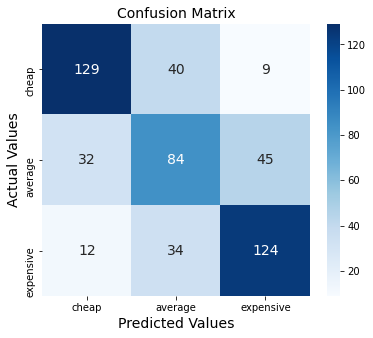

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.75      0.72      0.74       178
     average       0.53      0.52      0.53       161
   expensive       0.70      0.73      0.71       170

    accuracy                           0.66       509
   macro avg       0.66      0.66      0.66       509
weighted avg       0.66      0.66      0.66       509



In [55]:
tvec_knn_gs = run_model('tvec', 'knn', vec_params=tvec_params, mod_params=knn_params, grid_search=True)

### 3) Random Forest Classifier (with Grid Search hyperparameters)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.4s finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


### BEST PARAMS ###


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


{'preprocessor__text__cvec__max_features': None,
 'preprocessor__text__cvec__min_df': 1,
 'preprocessor__text__cvec__stop_words': 'english',
 'rfc__max_features': 0.1,
 'rfc__min_samples_leaf': 10,
 'rfc__n_estimators': 500}

### METRICS ###


{'model': 'rfc',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6045917170864404,
 'train': 0.7713178294573644,
 'test': 0.6227897838899804,
 'macro_avg_precision': 0.6125084284314848,
 'weighted_avg_precision': 0.6135345244325098,
 'macro_avg_recall': 0.6141398425515785,
 'weighted_avg_recall': 0.6227897838899804,
 'macro_avg_f1_score': 0.5941317502289839,
 'weighted_avg_f1_score': 0.5995197226951424}

### CONFUSION MATRIX ###


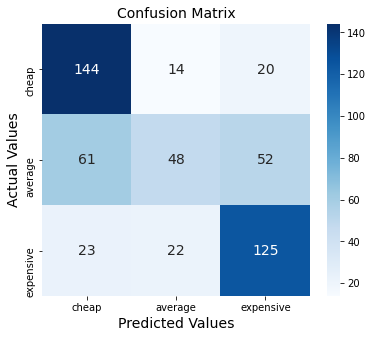

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.63      0.81      0.71       178
     average       0.57      0.30      0.39       161
   expensive       0.63      0.74      0.68       170

    accuracy                           0.62       509
   macro avg       0.61      0.61      0.59       509
weighted avg       0.61      0.62      0.60       509



In [56]:
cvec_rfc_gs = run_model('cvec', 'rfc', vec_params=cvec_params, mod_params=rfc_params, grid_search=True)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.3s finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


### BEST PARAMS ###


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


{'preprocessor__text__tvec__max_features': None,
 'preprocessor__text__tvec__min_df': 3,
 'preprocessor__text__tvec__stop_words': 'english',
 'rfc__max_features': 0.1,
 'rfc__min_samples_leaf': 15,
 'rfc__n_estimators': 1000}

### METRICS ###


{'model': 'rfc',
 'vectorizer': 'tvec',
 'cross_val_score': 0.6026077576098682,
 'train': 0.7538759689922481,
 'test': 0.5952848722986247,
 'macro_avg_precision': 0.5815239575013479,
 'weighted_avg_precision': 0.583089746706365,
 'macro_avg_recall': 0.5866910516038365,
 'weighted_avg_recall': 0.5952848722986247,
 'macro_avg_f1_score': 0.5657847353371213,
 'weighted_avg_f1_score': 0.5714154185578177}

### CONFUSION MATRIX ###


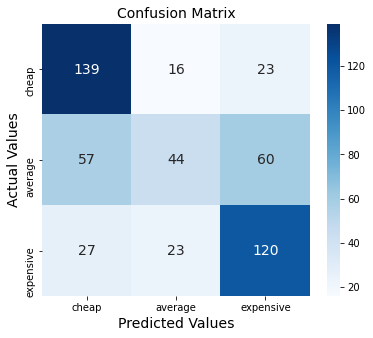

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.62      0.78      0.69       178
     average       0.53      0.27      0.36       161
   expensive       0.59      0.71      0.64       170

    accuracy                           0.60       509
   macro avg       0.58      0.59      0.57       509
weighted avg       0.58      0.60      0.57       509



In [57]:
tvec_rfc_gs = run_model('tvec', 'rfc', vec_params=tvec_params, mod_params=rfc_params, grid_search=True)

### 4) Support Vector Machine (with Grid Search hyperparameters)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]### BEST PARAMS ###


{'preprocessor__text__cvec__max_features': None,
 'preprocessor__text__cvec__min_df': 3,
 'preprocessor__text__cvec__stop_words': 'english',
 'svc__C': 1,
 'svc__gamma': 0.001,
 'svc__kernel': 'rbf'}

### METRICS ###


{'model': 'svc',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6617841564654567,
 'train': 0.812015503875969,
 'test': 0.724950884086444,
 'macro_avg_precision': 0.7205634037848804,
 'weighted_avg_precision': 0.7226298707555547,
 'macro_avg_recall': 0.7209449094733155,
 'weighted_avg_recall': 0.724950884086444,
 'macro_avg_f1_score': 0.7198564816667335,
 'weighted_avg_f1_score': 0.7228814239530947}

### CONFUSION MATRIX ###


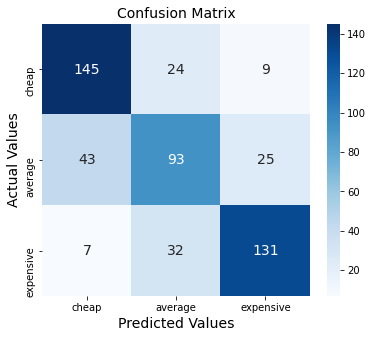

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.74      0.81      0.78       178
     average       0.62      0.58      0.60       161
   expensive       0.79      0.77      0.78       170

    accuracy                           0.72       509
   macro avg       0.72      0.72      0.72       509
weighted avg       0.72      0.72      0.72       509



In [58]:
cvec_svc_gs = run_model('cvec', 'svc', vec_params=cvec_params, mod_params=svc_params, grid_search=True)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LibSVM]### BEST PARAMS ###


{'preprocessor__text__tvec__max_features': 500,
 'preprocessor__text__tvec__min_df': 3,
 'preprocessor__text__tvec__stop_words': 'english',
 'svc__C': 0.1,
 'svc__gamma': 0.001,
 'svc__kernel': 'linear'}

### METRICS ###


{'model': 'svc',
 'vectorizer': 'tvec',
 'cross_val_score': 0.6918531025749262,
 'train': 0.8527131782945736,
 'test': 0.7347740667976425,
 'macro_avg_precision': 0.7297493983049881,
 'weighted_avg_precision': 0.7324984955803914,
 'macro_avg_recall': 0.7305940646898721,
 'weighted_avg_recall': 0.7347740667976425,
 'macro_avg_f1_score': 0.7296512792741453,
 'weighted_avg_f1_score': 0.7331060148750662}

### CONFUSION MATRIX ###


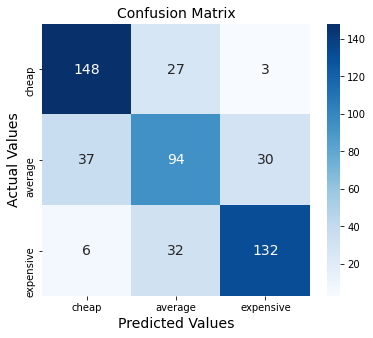

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.77      0.83      0.80       178
     average       0.61      0.58      0.60       161
   expensive       0.80      0.78      0.79       170

    accuracy                           0.73       509
   macro avg       0.73      0.73      0.73       509
weighted avg       0.73      0.73      0.73       509



In [59]:
tvec_svc_gs = run_model('tvec', 'svc', vec_params=tvec_params, mod_params=svc_params, grid_search=True)

### 5) Adaptive Boosting Classifier (with Grid Search hyperparameters)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
### BEST PARAMS ###


{'ada__learning_rate': 0.1,
 'ada__n_estimators': 500,
 'preprocessor__text__cvec__max_features': 500,
 'preprocessor__text__cvec__min_df': 2,
 'preprocessor__text__cvec__stop_words': 'english'}

### METRICS ###


{'model': 'ada',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6336991698325595,
 'train': 0.752906976744186,
 'test': 0.7131630648330058,
 'macro_avg_precision': 0.7355170923015163,
 'weighted_avg_precision': 0.7405028815538871,
 'macro_avg_recall': 0.7129564478453814,
 'weighted_avg_recall': 0.7131630648330058,
 'macro_avg_f1_score': 0.7169613257472537,
 'weighted_avg_f1_score': 0.7197004259803074}

### CONFUSION MATRIX ###


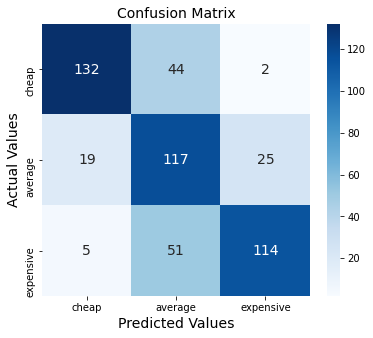

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.85      0.74      0.79       178
     average       0.55      0.73      0.63       161
   expensive       0.81      0.67      0.73       170

    accuracy                           0.71       509
   macro avg       0.74      0.71      0.72       509
weighted avg       0.74      0.71      0.72       509



In [60]:
cvec_ada_gs = run_model('cvec', 'ada', vec_params=cvec_params, mod_params=ada_params, grid_search=True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
### BEST PARAMS ###


{'ada__learning_rate': 0.1,
 'ada__n_estimators': 500,
 'preprocessor__text__tvec__max_features': 500,
 'preprocessor__text__tvec__min_df': 1,
 'preprocessor__text__tvec__stop_words': 'english'}

### METRICS ###


{'model': 'ada',
 'vectorizer': 'tvec',
 'cross_val_score': 0.614323906008161,
 'train': 0.752906976744186,
 'test': 0.6620825147347741,
 'macro_avg_precision': 0.6854444923165302,
 'weighted_avg_precision': 0.6910192155166504,
 'macro_avg_recall': 0.6609702796604718,
 'weighted_avg_recall': 0.6620825147347741,
 'macro_avg_f1_score': 0.6668992248701676,
 'weighted_avg_f1_score': 0.6703477856044598}

### CONFUSION MATRIX ###


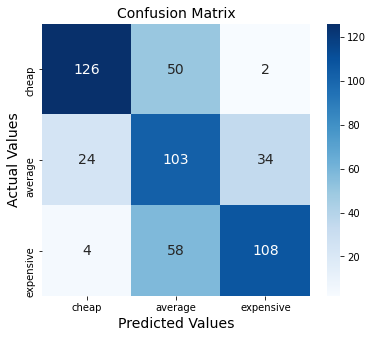

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.82      0.71      0.76       178
     average       0.49      0.64      0.55       161
   expensive       0.75      0.64      0.69       170

    accuracy                           0.66       509
   macro avg       0.69      0.66      0.67       509
weighted avg       0.69      0.66      0.67       509



In [61]:
tvec_ada_gs = run_model('tvec', 'ada', vec_params=tvec_params, mod_params=ada_params, grid_search=True)

### 6) Gradient Boosting Classifier (with Grid Search hyperparameters)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
      Iter       Train Loss   Remaining Time 
         1           1.0306           47.06s
         2           0.9768           39.43s
         3           0.9261           36.11s
         4           0.8810           36.71s
         5           0.8427           33.95s
         6           0.8098           32.09s
         7           0.7777           33.01s
         8           0.7512           33.63s
         9           0.7269           34.95s
        10           0.7027           33.69s
        20           0.5370           29.26s
        30           0.4421           29.47s
Fitting 5 folds for each of 36 candidates, totalling 180 fits
      Iter       Train Loss   Remaining Time 
         1           1.0306           20.90s
         2           0.9742           23.35s
         3           0.9261           28.71s
         4           0.8804           27.31s
         5           0.8414           24.90s
         6         

{'gbc__max_depth': 5,
 'gbc__n_estimators': 500,
 'preprocessor__text__cvec__max_features': None,
 'preprocessor__text__cvec__min_df': 2,
 'preprocessor__text__cvec__stop_words': 'english'}

### METRICS ###


{'model': 'gbc',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6336710285633883,
 'train': 0.9001937984496124,
 'test': 0.6817288801571709,
 'macro_avg_precision': 0.6698911319952043,
 'weighted_avg_precision': 0.6729359121381897,
 'macro_avg_recall': 0.6754821909222898,
 'weighted_avg_recall': 0.6817288801571709,
 'macro_avg_f1_score': 0.6702729779688497,
 'weighted_avg_f1_score': 0.6749206324459605}

### CONFUSION MATRIX ###


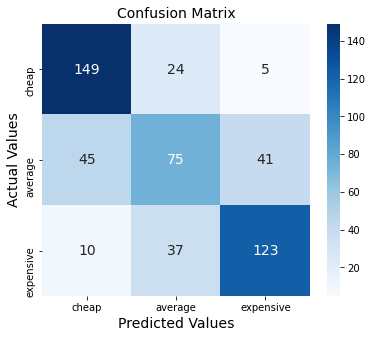

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.73      0.84      0.78       178
     average       0.55      0.47      0.51       161
   expensive       0.73      0.72      0.73       170

    accuracy                           0.68       509
   macro avg       0.67      0.68      0.67       509
weighted avg       0.67      0.68      0.67       509



In [62]:
cvec_gbc_gs = run_model('cvec', 'gbc', vec_params=cvec_params, mod_params=gbc_params, grid_search=True)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
      Iter       Train Loss   Remaining Time 
         1           1.0307           54.61s
         2           0.9756           55.83s
         3           0.9235           46.10s
         4           0.8769           42.30s
         5           0.8389           40.11s
         6           0.8030           38.94s
         7           0.7711           37.85s
         8           0.7397           37.06s
         9           0.7130           35.43s
        10           0.6905           35.70s
        20           0.5043           34.51s
Fitting 5 folds for each of 36 candidates, totalling 180 fits
      Iter       Train Loss   Remaining Time 
         1           1.0554           31.25s
         2           1.0200           27.49s
         3           0.9891           25.38s
         4           0.9591           24.85s
         5           0.9343           24.48s
         6           0.9121           21.65s
         7         

{'gbc__max_depth': 5,
 'gbc__n_estimators': 500,
 'preprocessor__text__tvec__max_features': 500,
 'preprocessor__text__tvec__min_df': 2,
 'preprocessor__text__tvec__stop_words': 'english'}

### METRICS ###


{'model': 'gbc',
 'vectorizer': 'tvec',
 'cross_val_score': 0.6220862060878944,
 'train': 0.9050387596899225,
 'test': 0.6365422396856582,
 'macro_avg_precision': 0.6222860529936408,
 'weighted_avg_precision': 0.6250469937875661,
 'macro_avg_recall': 0.6300382194890658,
 'weighted_avg_recall': 0.6365422396856582,
 'macro_avg_f1_score': 0.621178644643159,
 'weighted_avg_f1_score': 0.6259486693393723}

### CONFUSION MATRIX ###


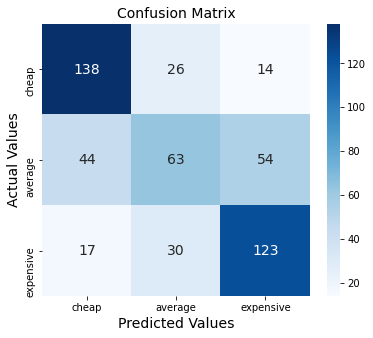

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.69      0.78      0.73       178
     average       0.53      0.39      0.45       161
   expensive       0.64      0.72      0.68       170

    accuracy                           0.64       509
   macro avg       0.62      0.63      0.62       509
weighted avg       0.63      0.64      0.63       509



In [63]:
tvec_gbc_gs = run_model('tvec', 'gbc', vec_params=tvec_params, mod_params=gbc_params, grid_search=True)

### 7) Extreme Gradient Boosting Classifier (with Grid Search hyperparameters)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
### BEST PARAMS ###


{'preprocessor__text__cvec__max_features': None,
 'preprocessor__text__cvec__min_df': 1,
 'preprocessor__text__cvec__stop_words': 'english',
 'xgb__eta': 0.001,
 'xgb__gamma': 0,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 500}

### METRICS ###


{'model': 'xgb',
 'vectorizer': 'cvec',
 'cross_val_score': 0.6453074433656958,
 'train': 1.0,
 'test': 0.7033398821218074,
 'macro_avg_precision': 0.6972441129561874,
 'weighted_avg_precision': 0.7002152225325509,
 'macro_avg_recall': 0.6991570639003036,
 'weighted_avg_recall': 0.7033398821218074,
 'macro_avg_f1_score': 0.697879085110345,
 'weighted_avg_f1_score': 0.7014563280015264}

### CONFUSION MATRIX ###


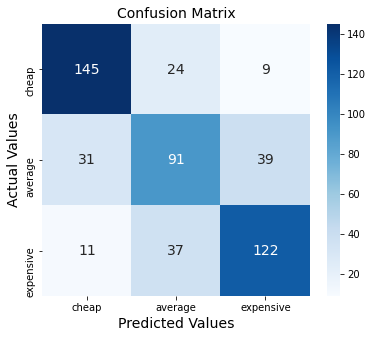

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.78      0.81      0.79       178
     average       0.60      0.57      0.58       161
   expensive       0.72      0.72      0.72       170

    accuracy                           0.70       509
   macro avg       0.70      0.70      0.70       509
weighted avg       0.70      0.70      0.70       509



In [64]:
cvec_xgb_gs = run_model('cvec', 'xgb', vec_params=cvec_params, mod_params=xgb_params, grid_search=True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
### BEST PARAMS ###


{'preprocessor__text__tvec__max_features': 500,
 'preprocessor__text__tvec__min_df': 3,
 'preprocessor__text__tvec__stop_words': 'english',
 'xgb__eta': 0.001,
 'xgb__gamma': 0.1,
 'xgb__max_depth': 5,
 'xgb__n_estimators': 50}

### METRICS ###


{'model': 'xgb',
 'vectorizer': 'tvec',
 'cross_val_score': 0.6375967356127761,
 'train': 0.9883720930232558,
 'test': 0.6679764243614931,
 'macro_avg_precision': 0.6649167141571541,
 'weighted_avg_precision': 0.6679576961963877,
 'macro_avg_recall': 0.6646797458602397,
 'weighted_avg_recall': 0.6679764243614931,
 'macro_avg_f1_score': 0.6647342995169082,
 'weighted_avg_f1_score': 0.6679015810646459}

### CONFUSION MATRIX ###


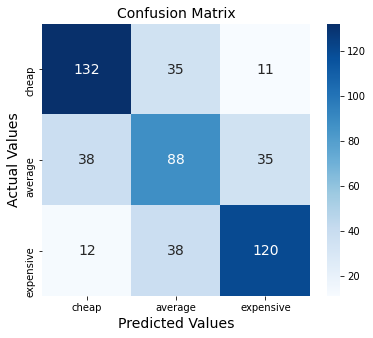

### CLASSIFICATION REPORT ###
              precision    recall  f1-score   support

       cheap       0.73      0.74      0.73       178
     average       0.55      0.55      0.55       161
   expensive       0.72      0.71      0.71       170

    accuracy                           0.67       509
   macro avg       0.66      0.66      0.66       509
weighted avg       0.67      0.67      0.67       509



In [65]:
tvec_xgb_gs = run_model('tvec', 'xgb', vec_params=tvec_params, mod_params=xgb_params, grid_search=True)

## 7.9. Evaluation of Models (with Grid Search hyperparameters)

In [66]:
# Create a dataframe to store evaluation scores with tuning
tuning_df = pd.DataFrame(tuning_list)

In [67]:
# Create a new column to reflect ('train > test') scores
# Positive ('train > test') scores = Overfitting
# Negative ('train > test') scores = Underfitting 
tuning_df['train > test'] = tuning_df['train'] - tuning_df['test'] 

In [68]:
# Evaluation scores of the models with tuning ranked by 'test' scores
tuning_df.sort_values(by='test', ascending = False).reset_index(drop=True)

,model,vectorizer,cross_val_score,train,test,macro_avg_precision,weighted_avg_precision,macro_avg_recall,weighted_avg_recall,macro_avg_f1_score,weighted_avg_f1_score,train > test
0,lr,tvec,0.683120,0.962209,0.744597,0.740332,0.743029,0.740727,0.744597,0.740155,0.743430,0.217612
1,lr,cvec,0.678280,0.944767,0.734774,0.728241,0.731116,0.730463,0.734774,0.728902,0.732498,0.209993
2,svc,tvec,0.691853,0.852713,0.734774,0.729749,0.732498,0.730594,0.734774,0.729651,0.733106,0.117939
3,svc,cvec,0.661784,0.812016,0.724951,0.720563,0.722630,0.720945,0.724951,0.719856,0.722881,0.087065
4,ada,cvec,0.633699,0.752907,0.713163,0.735517,0.740503,0.712956,0.713163,0.716961,0.719700,0.039744
5,xgb,cvec,0.645307,1.000000,0.703340,0.697244,0.700215,0.699157,0.703340,0.697879,0.701456,0.296660
6,knn,cvec,0.617237,1.000000,0.681729,0.675835,0.678569,0.677657,0.681729,0.676330,0.679731,0.318271
7,gbc,cvec,0.633671,0.900194,0.681729,0.669891,0.672936,0.675482,0.681729,0.670273,0.674921,0.218465
8,xgb,tvec,0.637597,0.988372,0.667976,0.664917,0.667958,0.664680,0.667976,0.664734,0.667902,0.320396
9,knn,tvec,0.594958,1.000000,0.662083,0.657980,0.661592,0.658623,0.662083,0.658111,0.661644,0.337917


In [69]:
# Evaluation score of the models without tuning
initial_df.sort_values(by='test', ascending = False).reset_index(drop=True)

,model,vectorizer,cross_val_score,train,test,macro_avg_precision,weighted_avg_precision,macro_avg_recall,weighted_avg_recall,macro_avg_f1_score,weighted_avg_f1_score,train > test
0,svc,cvec,0.687013,0.930233,0.754420,0.753934,0.756460,0.751693,0.754420,0.752382,0.755005,0.175812
1,lr,tvec,0.684105,0.918605,0.748527,0.744680,0.747467,0.744691,0.748527,0.744291,0.747592,0.170078
2,svc,tvec,0.679255,0.878876,0.736739,0.738872,0.742002,0.734487,0.736739,0.735948,0.738655,0.142137
3,lr,cvec,0.676333,1.000000,0.719057,0.716743,0.719504,0.715634,0.719057,0.715879,0.718962,0.280943
4,xgb,cvec,0.669556,1.000000,0.693517,0.687571,0.690351,0.689486,0.693517,0.688174,0.691582,0.306483
5,ada,cvec,0.634647,0.694767,0.689587,0.685939,0.689452,0.685939,0.689587,0.685922,0.689503,0.005180
6,gbc,cvec,0.616252,0.808140,0.660118,0.645052,0.647837,0.653103,0.660118,0.644192,0.649183,0.148022
7,rfc,cvec,0.620098,1.000000,0.654224,0.652463,0.652657,0.646804,0.654224,0.636222,0.640260,0.345776
8,rfc,tvec,0.619075,1.000000,0.654224,0.652258,0.652708,0.646187,0.654224,0.634880,0.639234,0.345776
9,xgb,tvec,0.654003,1.000000,0.650295,0.650198,0.653127,0.647407,0.650295,0.648291,0.651200,0.349705


### Accuracy Score ('train' and 'test')

All the tuned and un-tuned models had outperformed the baseline model. Generally, the tuned models had improved accuracy scores on the unseen data ('test') and both the Support Vector Machine Classifier and Multi-class Logistic Regression performed fairly well. Our best performing models were as follows, with 2 models having a tie at second place:
   1) Multi-class Logistic Regression with TfidfVectorizer (accuracy score = 0.744597)
   2) Multi-class Logistic Regression with with CountVectorizer (accuracy score = 0.734774)  
   2) Support Vector Machine Classifier with TfidfVectorizer (accuracy score = 0.734774)   

There was also a lift of 0.394892 in terms of accuracy score of the Multi-class Logistic Regression with TfidfVectorizer from the baseline model of 0.349705. It was able to generalize unseen data better as indicated by the narrow difference between the 'train' and 'test' scores of 0.217612. 

As such, the **Multi-class Logistic Regression with TfidfVectorizer** is our selected model with the best outcome. 

## 7.10. Model Selection

In [224]:
# Check each step of the pipeline in our Multi-class Logistic Regression with TfidfVectorizer
# source: https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn
tvec_lr_gs.best_estimator_.steps

[('preprocessor',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('text',
                                   Pipeline(steps=[('tvec',
                                                    TfidfVectorizer(analyzer=<function separate_ingr at 0x000001A0B3B690D0>,
                                                                    stop_words='english'))]),
                                   'ingredients_list'),
                                  ('numeric',
                                   Pipeline(steps=[('ss', StandardScaler())]),
                                   ['av_rating', 'sum_reviews', 'sum_love',
                                    'skintype_sensitive', 'skintype_combination',
                                    'skintype_nor...
                                    'concerns_darkspots', 'concerns_darkcircles',
                                    'concerns_puffiness', 'concerns_pores',
                                    'concerns_wrinkles', 'concern

In [225]:
# Best model
best_mod = tvec_lr_gs.best_estimator_.steps[1][1]
best_mod

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='saga',
                   verbose=1)

In [226]:
# Best vectorizer
# Source: https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer
best_vec = tvec_lr_gs.best_estimator_.steps[0][1].transformers_[0][1].steps[0][1]
best_vec

TfidfVectorizer(analyzer=<function separate_ingr at 0x000001A0B3B690D0>,
                stop_words='english')

In [227]:
# Best params
best_params = tvec_lr_gs.best_params_
best_params

{'lr__C': 10,
 'lr__penalty': 'l2',
 'lr__solver': 'saga',
 'preprocessor__text__tvec__max_features': None,
 'preprocessor__text__tvec__min_df': 1,
 'preprocessor__text__tvec__stop_words': 'english'}

In [228]:
# Generate accuracy score
score = tvec_lr_gs.score(X_test, y_test)
score

0.7445972495088409

###  Predictions

In [229]:
# Generate predictions
predictions = tvec_lr_gs.predict(X_test)

# Uncomment below to check
#predictions

In [230]:
# Generate predicted probabilities
prediction_proba = np.round(tvec_lr_gs.predict_proba(X_test), 3)  

# Uncomment below to check
#prediction_proba 

In [231]:
# Generate actuals
y_test_array = np.ravel(y_test)

# Uncomment below to check
#y_test_array

In [232]:
# X_test array
X_test_array = X_test['ingredients_list'].to_numpy()

# Uncomment below to check
#X_test_array

In [233]:
# Create a dataframe to store predictions and rename columns
predictions_df = pd.DataFrame(prediction_proba)
predictions_df['ingredients_list'] = X_test_array 
predictions_df['predictions'] = predictions
predictions_df['actual'] = y_test_array
predictions_df['X_test_index'] = X_test.index

# Create index column in main dataframe for mapping
df['df_index'] = df.index

# Rename columns
predictions_df.columns = ['1_pred_proba', '2_pred_proba', '3_pred_proba', 'ingredients_list', 'predictions', 
                          'actual', 'X_test_index']

In [234]:
# Add 'product_name','value_price', 'price_per_unit_vol' columns for ease of reference
predictions_df = pd.merge(predictions_df, df[['product_name','value_price', 'price_per_unit_vol','df_index']],
                          how="left", left_on ='X_test_index', right_on = 'df_index')

# Drop index columns
predictions_df = predictions_df.drop(columns =['X_test_index', 'df_index'])

# Reorder columns
predictions_df = predictions_df[['product_name', 'value_price', 'price_per_unit_vol', 'actual', 'predictions','1_pred_proba',
                                 '2_pred_proba', '3_pred_proba', 'ingredients_list']]

# Preview predictions dataframe
predictions_df.head(10)

,product_name,value_price,price_per_unit_vol,actual,predictions,1_pred_proba,2_pred_proba,3_pred_proba,ingredients_list
0,SEPHORA COLLECTION Own it Butt Sheet Mask - Balancing + Purifying,8.0,0.27,1,1,1.000,0.000,0.000,"aloe vera juice, tumeric, and sodium lactate, pineapple, aqua water, glyceride, polyglycerin, di..."
1,Kate Somerville Daily Deflector™ Waterlight Broad Spectrum SPF 50+ PA+++ Anti-Aging Sunscreen,48.0,0.95,2,2,0.018,0.718,0.265,"titanium dioxide and zinc oxide, matrixyl, dynamic moisture complex, shiitake mushroom, water, d..."
2,Glow Recipe Watermelon Glow Ultra-Fine Mist,28.0,0.37,1,1,0.488,0.346,0.166,"watermelon, and hyaluronic acid, hibuscus flower aha, acv apple cider vinegar citrullus lanatus ..."
3,SOBEL SKIN Rx 15% Niacinamide Gel Serum,75.0,1.50,3,3,0.000,0.068,0.932,"acinamide, lanolin, sigesbeckia orientalis water, acinamide, glyceride, hydroxyethyl, lanolin, c..."
4,Primera Chamomile Micellar Cleansing Water,32.0,0.11,1,1,0.861,0.130,0.009,"witch hazel extract, chamomile water, euk propanediol, polyglycerin, caprate, polyglycerin, dila..."
5,Saturday Skin Rub-A-Dub Refining Peel Gel,28.0,0.37,1,1,0.894,0.106,0.000,"papain papaya, bromelain pineapple, aloe barbadensis leaf polysaccharides, glyceride, cellulose,..."
6,OLEHENRIKSEN C-Rush™ Vitamin C Gel Moisturizer,46.0,0.92,2,2,0.230,0.743,0.027,"sources of vitamin c, o, ascorbic acid, tetrahexydecyl ascorbate, rose of winter water, glycerid..."
7,Algenist Advanced Anti-Aging Repairing Oil,82.0,2.73,3,3,0.000,0.019,0.981,"microalgae, ceramide, algae extract, rosemary extract and sunflower seed oil, chlorella protothe..."
8,Herbivore Emerald Hemp Seed Deep Moisture Glow Oil,48.0,1.60,2,3,0.002,0.038,0.961,"chia seed co, squalane, foam seed oil, cannabis sativa hemp seed oil, capric triglycerides fract..."
9,BeautyBio The Pout Sparkling Rosé Hyaluronic Acid Collagen Plumping Lip Serum,35.0,2.33,1,1,0.997,0.000,0.003,"and hyaluronic acid, collagen, hydrogenated sunflower seed oil polyglyceryl, ethylene propylene ..."


### Misclassification

In [235]:
# Filter out wrong predictions (130)
wrong_predictions = predictions_df[predictions_df['actual']!=predictions_df['predictions']]
wrong_predictions.head()

,product_name,value_price,price_per_unit_vol,actual,predictions,1_pred_proba,2_pred_proba,3_pred_proba,ingredients_list
8,Herbivore Emerald Hemp Seed Deep Moisture Glow Oil,48.0,1.60,2,3,0.002,0.038,0.961,"chia seed co, squalane, foam seed oil, cannabis sativa hemp seed oil, capric triglycerides fract..."
13,philosophy anti-wrinkle miracle worker eye+ line-correcting eye cream,60.0,4.00,3,2,0.004,0.512,0.484,"cyclohexasiloxane, ethylene methacrylate copolymer, caprylic capric, c, alkyl benzoate, tetrahex..."
15,Perricone MD No:Rinse Exfoliating Peel,45.0,0.76,2,3,0.000,0.061,0.939,"water, carnatine, urea, maltodextrin, phatidylcholine, dimethyl mea, gluconolacctone, magnesium ..."
16,Caudalie Vinoperfect Brightening Moisturizer with Niacinamide,59.0,1.18,3,2,0.223,0.500,0.277,"viniferin, acinamide, and hyaluronic acid, glyceride, dicapryl carbonate, squalane, l octyldodec..."
18,Dermalogica Prisma Protect SPF 30 Moisturizer,65.0,1.30,3,2,0.120,0.533,0.347,"matchawater, homosalate, and octocrylene, silica, butelyene glycol, ethylhexyl olivate, butyl me..."


In [236]:
# False positives for '1-cheap' class - '2-average' products which were incorrectly predicted as '1-cheap'   (35)
wrong_predictions[(wrong_predictions['predictions'] == 1)  & (wrong_predictions['actual'] == 2)].sort_values (
    by='1_pred_proba', ascending = False).shape

(35, 9)

In [237]:
# False positives for '1-cheap' class - '3-average' products which were incorrectly predicted as '1-cheap' (6)
wrong_predictions[(wrong_predictions['predictions'] == 1) & (wrong_predictions['actual'] == 3)].sort_values (
    by='1_pred_proba', ascending = False).shape

(6, 9)

In [238]:
# False negatives for '1-cheap' class - '1-cheap' products which were incorrectly predicted as '2-average'  (28)
wrong_predictions[(wrong_predictions['predictions'] == 2) & (wrong_predictions['actual'] == 1)].sort_values (
    by='1_pred_proba', ascending = False).shape

(28, 9)

In [239]:
# False negatives for '1-cheap' class - '1-cheap' products which were incorrectly predicted as '3-average'  (2)
wrong_predictions[(wrong_predictions['predictions'] == 3) & (wrong_predictions['actual'] == 1)].sort_values (
    by='1_pred_proba', ascending = False).shape

(2, 9)

###  Confusion Matrix

In [240]:
# Plot confusion matrix for '1-cheap'
# Source: https://www.youtube.com/watch?v=FAr2GmWNbT0
cm = confusion_matrix(y_test, predictions)    # both are in arrays
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TP = ' + str(value[0]), 'FN = ' + str(value[1]), 'FN = ' + str(value[2])])
    if index == 1:
        modified_cm.append(['FP = ' + str(value[0]), 'TN = ' + str(value[1]), 'TN = ' + str(value[2])])
    if index == 2:
        modified_cm.append(['FP = ' + str(value[0]), 'TN = ' + str(value[1]), 'TN = ' + str(value[2])]) 

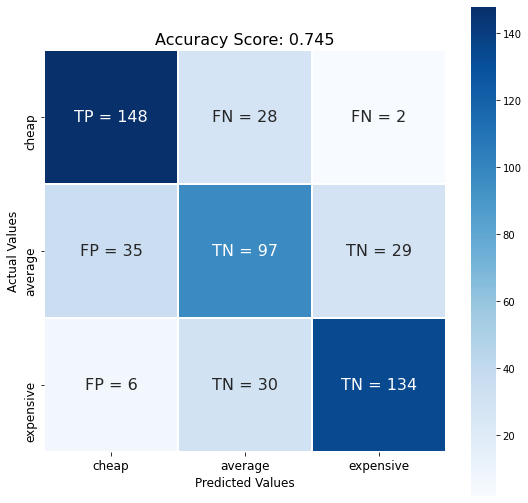

In [241]:
# Plot confusion matrix for '1-cheap'
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 16},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['cheap', 'average', 'expensive'],
            yticklabels = ['cheap', 'average', 'expensive'],
            );

plt.ylabel('Actual Values', fontsize = 12);
plt.xlabel('Predicted Values', fontsize = 12);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 16);
plt.tick_params(labelsize= 12)

# Save plot
plt.savefig('../plots/confusion_matrix_1.png', dpi=150, bbox_inches='tight')

From the confusion matrix above, the model seemed to be able to predict True Positives and False Positives well.

**True Positive** : Cheap products which were correctly predicted.

**True Negative** : Average and expensive products which were correctly predicted as not cheap.

**False Positive** : Average and expensive products which were incorrectly predicted as cheap.

**False Negative** : Cheap products which were incorrectly predicted as either average or expensive.

In [242]:
# Plot confusion matrix for '2-average'
cm = confusion_matrix(y_test, predictions)    # both are in arrays
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1]), 'TN = ' + str(value[2])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1]), 'FN = ' + str(value[2])])
    if index == 2:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1]), 'TN = ' + str(value[2])]) 

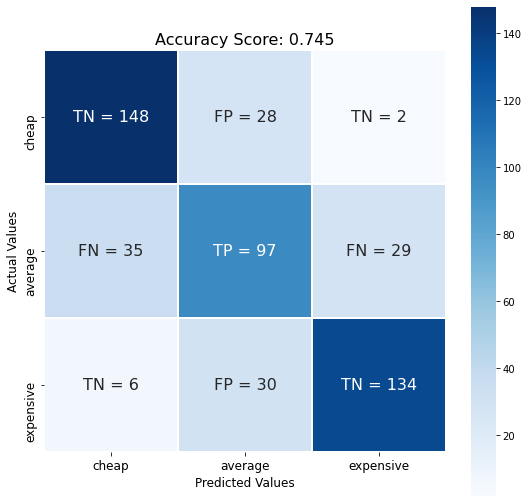

In [243]:
# Plot confusion matrix for '2-average'
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 16},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['cheap', 'average', 'expensive'],
            yticklabels = ['cheap', 'average', 'expensive'],
            );

plt.ylabel('Actual Values', fontsize = 12);
plt.xlabel('Predicted Values', fontsize = 12);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 16);
plt.tick_params(labelsize= 12)

# Save plot
plt.savefig('../plots/confusion_matrix_2.png', dpi=150, bbox_inches='tight')

In [244]:
# Plot confusion matrix for '3-expensive'
cm = confusion_matrix(y_test, predictions)    # both are in arrays
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'TN = ' + str(value[1]), 'FP = ' + str(value[2])])
    if index == 1:
        modified_cm.append(['TN = ' + str(value[0]), 'TN = ' + str(value[1]), 'FP = ' + str(value[2])])
    if index == 2:
        modified_cm.append(['FN = ' + str(value[0]), 'FN = ' + str(value[1]), 'TP = ' + str(value[2])]) 

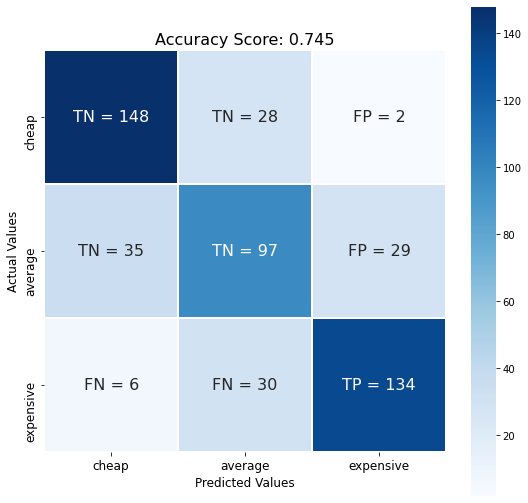

In [245]:
# Plot confusion matrix for '3-expensive'
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 16},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['cheap', 'average', 'expensive'],
            yticklabels = ['cheap', 'average', 'expensive'],
            );

plt.ylabel('Actual Values', fontsize = 12);
plt.xlabel('Predicted Values', fontsize = 12);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 16);
plt.tick_params(labelsize= 12)

# Save plot
plt.savefig('../plots/confusion_matrix_3.png', dpi=150, bbox_inches='tight')

###  Coefficients

In [246]:
# Store coefficients of model in a dataframe and rename columns as 'coef'
coef_df = pd.DataFrame(best_mod.coef_).transpose()
# coef_df.columns = ['1-cheap', '2-average', '3-expensive']

# Uncomment below to check
#coef_df

As the coefficients of logistic regression are in log odds, the exponent of coefficients are also computed below to get the odds ratio for the ease of interpretation of the effect of a change in the features on the y-variable. 

Overall, there are specific brands that are strong predictors of price for each class. Product category is more important in predicting cheaper products. Products with ingredients that are non-toxic or have anti-aging properties are more expensive.

In [247]:
# Create a function to plot feature importance
def plot_feature_importance(model, training_columns, method='abs_value', price_range_col= 0, size=(12,25), n=-1):
    '''
    INPUT:
    model - fitted model such that there is a coefficient for the various features
    training_columns - X_train.columns 
    method - how to sort the graph ('abs_value' or 'coef')
    size - plot figure size
    price_range_col - referent class: '1- cheap' for '0', '2- average' for '1', '3- expensive' for '2' 
    n - top n number of features to show (n=-1 to show all features)
    
    OUTPUT:
    Feature importance 
    '''
    fittedmodel = model
    title= model
    
    print('Model: ',title)
    
    if n<0:
        n= len(training_columns)
    print('Number of features displayed: {}/{}'.format(n, len(training_columns)))
    
    coef = np.transpose(fittedmodel.coef_.tolist()[price_range_col])  
    model_features= pd.DataFrame(zip(training_columns, coef, abs(coef)), columns=['features', 'coef', 'abs_value'])
    model_features['exp_coef'] = np.exp(model_features['coef'])   # We need to compute exponents of coefficients
    model_features = model_features.sort_values(method, ascending=False)
    
    zeroed = model_features[model_features.coef==0]
    print(f'Number of features with 0 coefficient: {len(zeroed)}')
    
    plt.figure(figsize=size)
    sns.barplot(y=model_features.features[:n], x=model_features.coef[:n], orient='h', color='#f4cbcdff')
    plt.title('Feature Importance', fontsize =16)

    plt.show()
    print(model_features)

Model:  LogisticRegression(C=10, max_iter=1000, random_state=42, solver='saga',
                   verbose=1)
Number of features displayed: 153/153
Number of features with 0 coefficient: 0


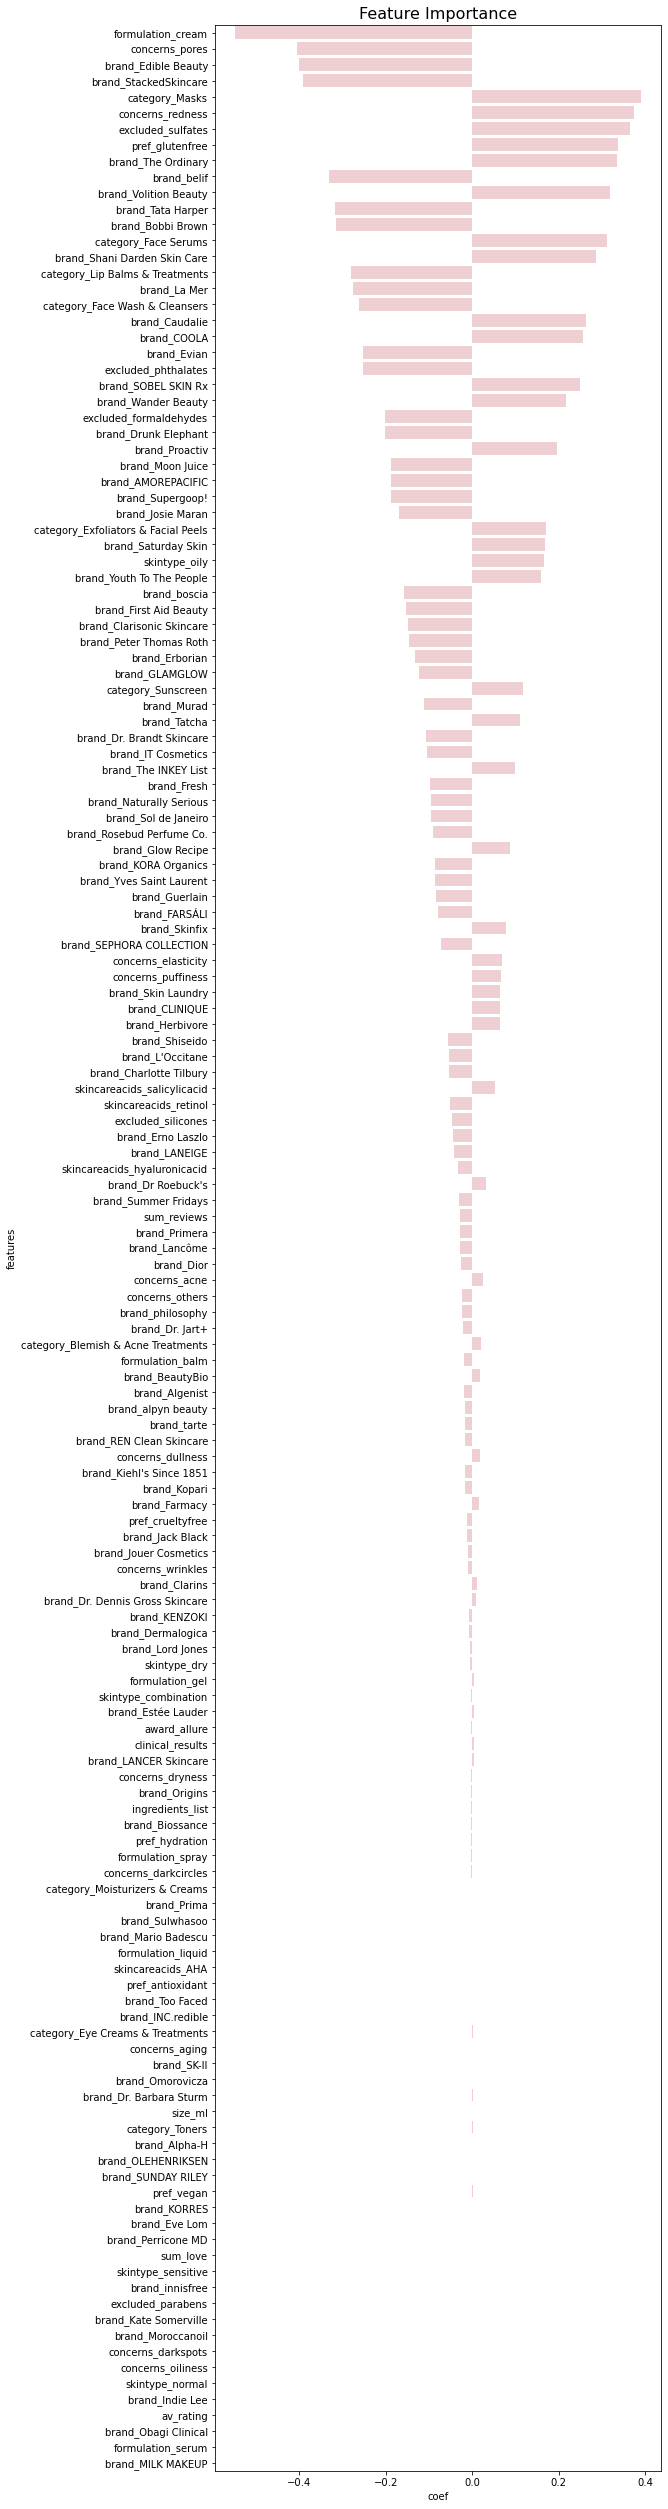

                                features      coef  abs_value  exp_coef
35                     formulation_cream -0.548562   0.548562  0.577780
14                        concerns_pores -0.405588   0.405588  0.666585
64                   brand_Edible Beauty -0.401301   0.401301  0.669448
123                brand_StackedSkincare -0.392433   0.392433  0.675411
148                       category_Masks  0.390468   0.390468  1.477672
17                      concerns_redness  0.374387   0.374387  1.454100
31                     excluded_sulfates  0.364509   0.364509  1.439806
23                       pref_glutenfree  0.337531   0.337531  1.401483
130                   brand_The Ordinary  0.333733   0.333733  1.396171
137                          brand_belif -0.331083   0.331083  0.718146
132                brand_Volition Beauty  0.317959   0.317959  1.374320
127                    brand_Tata Harper -0.317364   0.317364  0.728065
49                     brand_Bobbi Brown -0.315702   0.315702  0

In [248]:
# Plot feature importance where referent class = 1 - cheap
plot_feature_importance(best_mod, X_train.columns, 'abs_value', price_range_col = 0, size = (8, 45))


Features in multi-class logistic regression function similarly to binary logistic regression, with one difference that we will need separate weight vectors (and biases) for each of the 3 classes. In binary classification a positive coefficient on a feature influences the classifier toward y = 1 and a negative coefficient influences it toward y = 0 with the absolute value indicating how important the feature is. For multi-class logistic regression, by contrast, with separate weights for each
class, a feature can be evidence for or against each individual class.

In the above plot, we have assigned the referent class as '1-cheap'. Therefore, the coefficients are interpreted relative to '1-cheap'. For a product with 'category_masks', the multi-class log-odds for classifying it in class '1-cheap', would be expected to increase by 0.390468 unit while holding all other variables in the model constant. The odds of classifying a product with 'category_masks' in class '1-cheap' is 1.48 times higher (np.exp(0.390468) = 1.4776) , regardless of the other variables.

Model:  LogisticRegression(C=10, max_iter=1000, random_state=42, solver='saga',
                   verbose=1)
Number of features displayed: 153/153
Number of features with 0 coefficient: 0


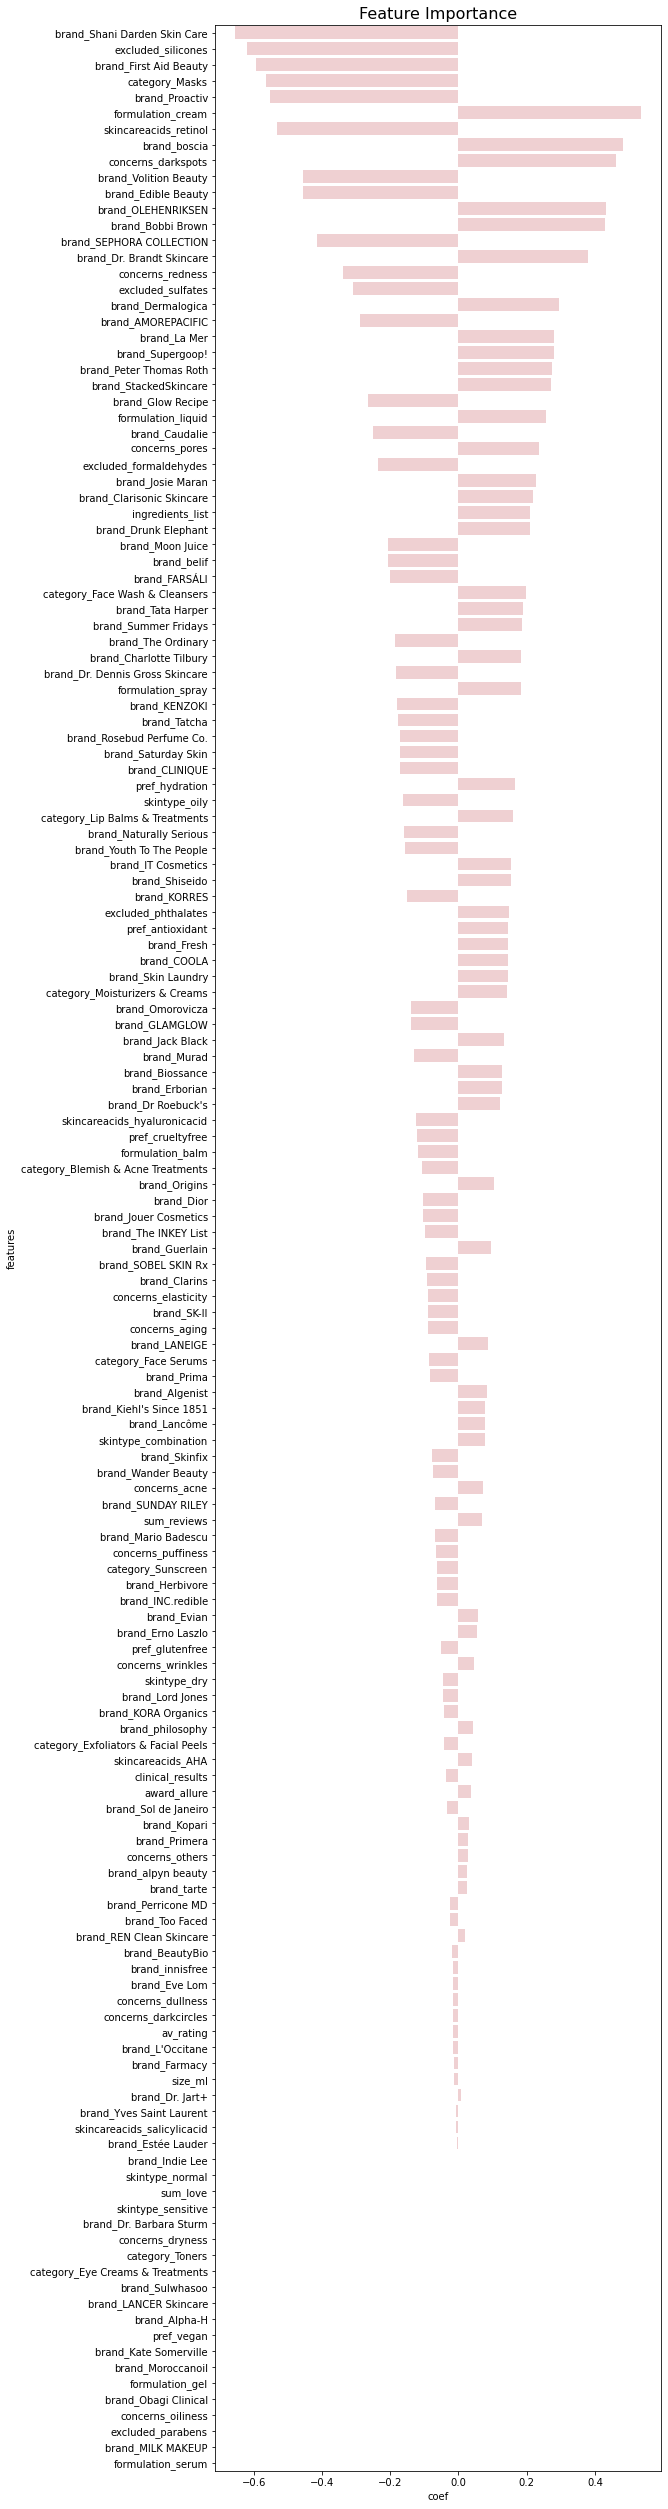

                                features      coef  abs_value  exp_coef
118         brand_Shani Darden Skin Care -0.654309   0.654309  0.519801
34                    excluded_silicones -0.619406   0.619406  0.538264
72                brand_First Aid Beauty -0.592263   0.592263  0.553074
148                       category_Masks -0.564726   0.564726  0.568516
110                       brand_Proactiv -0.551907   0.551907  0.575850
35                     formulation_cream  0.535330   0.535330  1.708013
29                 skincareacids_retinol -0.533111   0.533111  0.586777
138                         brand_boscia  0.483830   0.483830  1.622276
11                    concerns_darkspots  0.463108   0.463108  1.589005
132                brand_Volition Beauty -0.454750   0.454750  0.634606
64                   brand_Edible Beauty -0.454587   0.454587  0.634710
102                   brand_OLEHENRIKSEN  0.431183   0.431183  1.539078
49                     brand_Bobbi Brown  0.428210   0.428210  1

In [249]:
# Plot feature importance where referent class = 2 - average
plot_feature_importance(best_mod, X_train.columns, 'abs_value', price_range_col = 1, size = (8, 45))

In the above plot, we have assigned the referent class as '2-average'. Therefore, the coefficients are interpreted relative to '2-average'. For a product with 'formulation_cream', the multi-class log-odds for classifying it in class '2-average', would be expected to increase by 0.535330 unit while holding all other variables in the model constant. The odds of classifying a product with 'formulation_cream' in class '2-average' is 1.71 times higher (np.exp(0.535330) = 1.708013) , regardless of the other variables.

Model:  LogisticRegression(C=10, max_iter=1000, random_state=42, solver='saga',
                   verbose=1)
Number of features displayed: 153/153
Number of features with 0 coefficient: 0


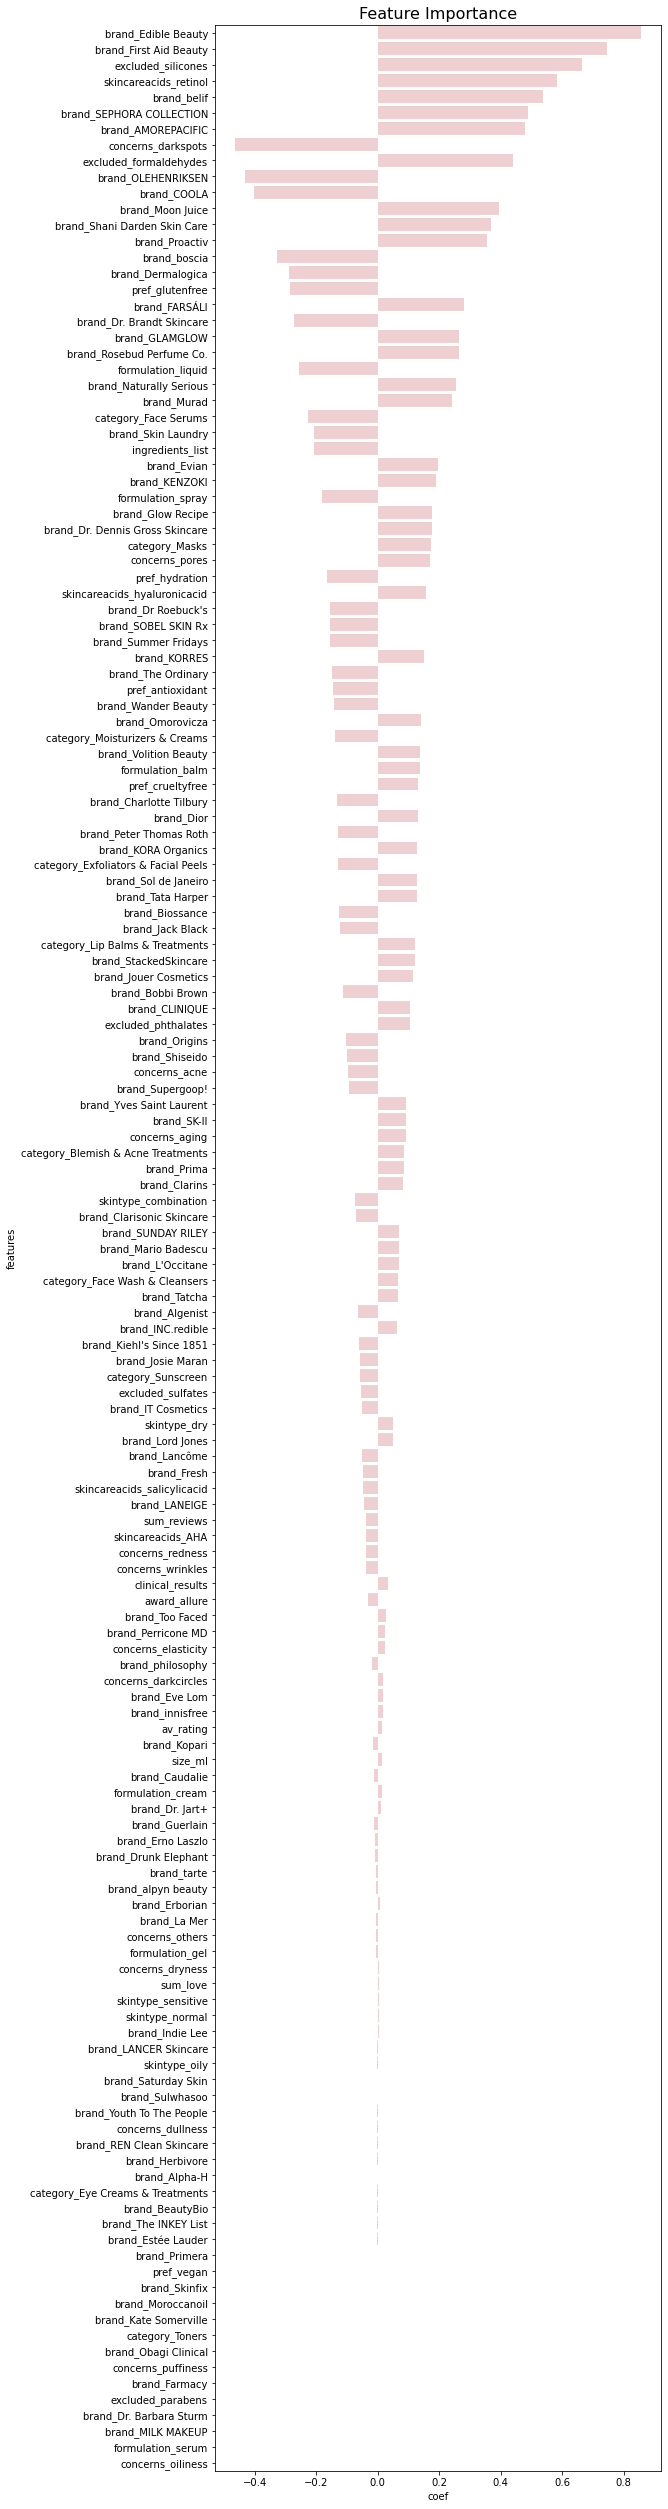

                                features      coef  abs_value  exp_coef
64                   brand_Edible Beauty  0.855888   0.855888  2.353463
72                brand_First Aid Beauty  0.746200   0.746200  2.108970
34                    excluded_silicones  0.665519   0.665519  1.945500
29                 skincareacids_retinol  0.583953   0.583953  1.793112
137                          brand_belif  0.537049   0.537049  1.710950
113             brand_SEPHORA COLLECTION  0.487313   0.487313  1.627937
44                    brand_AMOREPACIFIC  0.477657   0.477657  1.612292
11                    concerns_darkspots -0.463030   0.463030  0.629373
32                excluded_formaldehydes  0.439102   0.439102  1.551314
102                   brand_OLEHENRIKSEN -0.430552   0.430552  0.650150
51                           brand_COOLA -0.402510   0.402510  0.668639
98                      brand_Moon Juice  0.395711   0.395711  1.485440
118         brand_Shani Darden Skin Care  0.368253   0.368253  1

In [250]:
# Plot feature importance where referent class = 3 - expensive
plot_feature_importance(best_mod, X_train.columns, 'abs_value', price_range_col = 2, size = (8, 45))

In the above plot, we have assigned the referent class as '3-expensive'. Therefore, the coefficients are interpreted relative to '3-expensive'. For a product with 'brand_Edible Beauty', the multi-class log-odds for classifying it in class '3-expensive', would be expected to increase by 0.855888 unit while holding all other variables in the model constant. The odds of classifying a product with 'brand_Edible Beauty' in class '3-expensive' is 2.35 times higher (np.exp(0.855888) = 2.353463) , regardless of the other variables.

### Top Ingredient Terms

In general, plant-based ingredients are associated with average- expensive products while cheaper products have more alcohol derivatives. 

In [251]:
# Store coefficients of model in a dataframe and rename columns as 'coef'
coef_ingr_df = coef_df.copy()
coef_ingr_df.columns =['1-cheap', '2-average', '3-expensive']

In [252]:
# Rename columns
coef_ingr_df['1-cheap_exp'] = np.exp(coef_ingr_df['1-cheap'])
coef_ingr_df['2-average_exp'] = np.exp(coef_ingr_df['2-average'])
coef_ingr_df['3-expensive_exp'] = np.exp(coef_ingr_df['3-expensive'])

In [253]:
# Array mapping from feature integer indices to feature name
top_ingr = pd.DataFrame(best_vec.get_feature_names())
top_ingr.columns = ['ingredient_terms']

In [254]:
# Create datadrame for top ingredients coefficients
top_ingr_df = pd.concat([top_ingr, coef_ingr_df], axis=1, join='inner')
top_ingr_df.head()

,ingredient_terms,1-cheap,2-average,3-expensive,1-cheap_exp,2-average_exp,3-expensive_exp
0,a blend of essential amino acids and calcium,-0.000034,-0.015456,0.015490,0.999966,0.984663,1.015611
1,a ginger root pore,-0.028850,0.068091,-0.039242,0.971563,1.070463,0.961518
2,a natural blend of bidens pilosa extract spanish needles and palm,-0.000160,-0.002582,0.002742,0.999840,0.997421,1.002746
3,a natural retinol,-0.000160,-0.002582,0.002742,0.999840,0.997421,1.002746
4,a powerful prebiotic,-0.004096,0.078384,-0.074288,0.995912,1.081538,0.928404


In [255]:
# Top ingredients correlated with '1-cheap'
top_ingr_cheap_df = top_ingr_df.sort_values('1-cheap_exp', ascending = False).head(15).reset_index(drop=True)
top_ingr_cheap_df

,ingredient_terms,1-cheap,2-average,3-expensive,1-cheap_exp,2-average_exp,3-expensive_exp
0,glycoproteins,0.800584,-0.217784,-0.582801,2.226842,0.804299,0.558332
1,silver birch bud extract,0.774816,-0.263553,-0.511263,2.170193,0.768317,0.599738
2,ci iron oxides,0.769817,-0.329362,-0.440455,2.159371,0.719383,0.643743
3,capryloyl glycine,0.748129,0.278905,-1.027033,2.113042,1.321681,0.358068
4,colloidal oatmeal,0.735094,-0.421696,-0.313397,2.085677,0.655933,0.730960
5,sweet almond oil allantoin,0.725752,-0.373147,-0.352605,2.066284,0.688564,0.702855
6,octyldodecanol,0.710551,0.022138,-0.732689,2.035112,1.022385,0.480615
7,hydrogenated,0.697310,-0.682001,-0.015308,2.008342,0.505604,0.984808
8,terpineol,0.692847,-0.536706,-0.156141,1.999400,0.584671,0.855438
9,capryl glycol,0.681936,-0.002960,-0.678975,1.977702,0.997044,0.507136


Text(0.5, 1.0, 'Top 15 Ingredient Terms Correlated with Cheap')

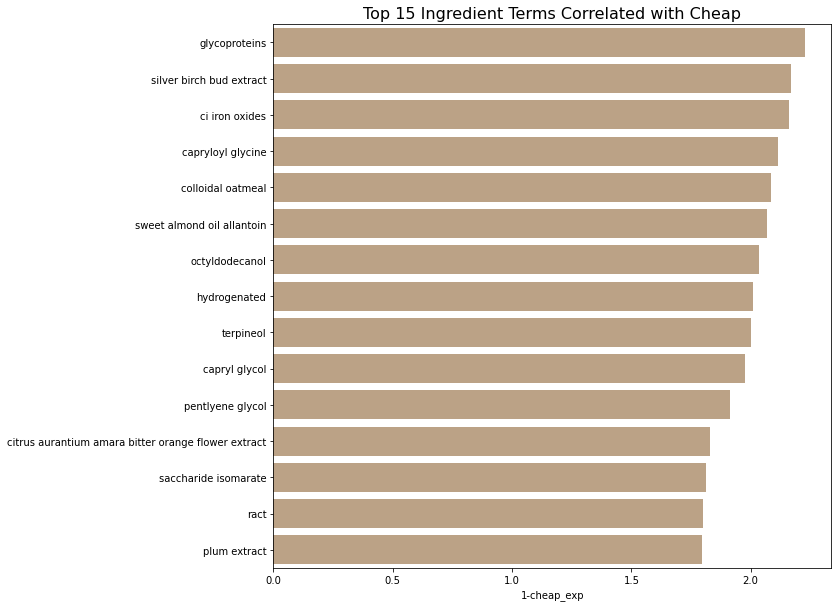

In [256]:
# Plot top ingredients correlated with '1-cheap'
plt.figure(figsize=(10,10))
sns.barplot(data=top_ingr_cheap_df, x=top_ingr_cheap_df['1-cheap_exp'], y='ingredient_terms', color='#c4a27dff')
plt.ylabel('')
plt.title('Top 15 Ingredient Terms Correlated with Cheap', fontsize=16)

In [257]:
# Top ingredients correlated with '2-average'
top_ingr_average_df = top_ingr_df.sort_values('2-average_exp', ascending = False).head(15).reset_index(drop=True)
top_ingr_average_df

,ingredient_terms,1-cheap,2-average,3-expensive,1-cheap_exp,2-average_exp,3-expensive_exp
0,vitamin,-0.515029,1.829348,-1.314319,0.597483,6.229826,0.268657
1,glyceryl stea,-0.825795,1.317814,-0.492020,0.437887,3.735248,0.611390
2,organic vaccinium macrocarpon cranberry extract,-0.568019,1.117594,-0.549576,0.566647,3.057490,0.577195
3,talc,-0.302899,1.087240,-0.784340,0.738673,2.966075,0.456421
4,octisalate ingredients,-0.003920,0.921245,-0.917325,0.996088,2.512417,0.399586
5,theobroma cacao cocoa extract,-0.617186,0.903198,-0.286012,0.539460,2.467481,0.751254
6,rosa damascena flower,-0.290462,0.889186,-0.598724,0.747918,2.433147,0.549513
7,tetrahydrobisdemethoxydiferulolymethane,-0.186749,0.880650,-0.693902,0.829652,2.412468,0.499623
8,caprylic capric,-0.444012,0.873354,-0.429342,0.641458,2.394930,0.650937
9,behenyl alcohol,-0.671284,0.833252,-0.161968,0.511052,2.300788,0.850469


Text(0.5, 1.0, 'Top 15 Ingredient Terms Correlated with Average')

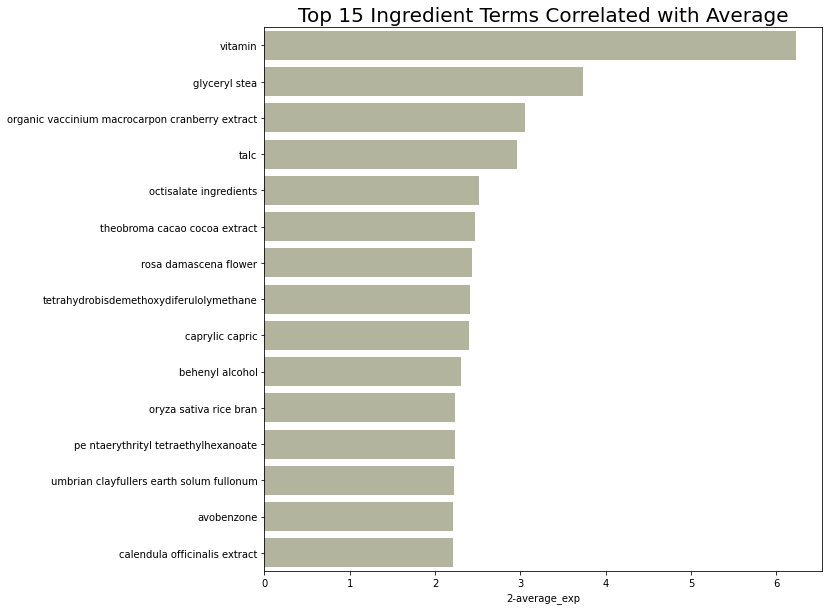

In [258]:
# Plot top ingredients correlated with '2-average'
plt.figure(figsize=(10,10))
sns.barplot(data=top_ingr_average_df, x=top_ingr_average_df['2-average_exp'], y='ingredient_terms', color='#b5b79bff')
plt.ylabel('')
plt.title('Top 15 Ingredient Terms Correlated with Average', fontsize=20)

In [259]:
# Top ingredients correlated with '3-expensive'
top_ingr_expensive_df = top_ingr_df.sort_values('3-expensive_exp', ascending = False).head(15).reset_index(drop=True)
top_ingr_expensive_df

,ingredient_terms,1-cheap,2-average,3-expensive,1-cheap_exp,2-average_exp,3-expensive_exp
0,glycereth,-0.321084,-0.803298,1.124382,0.725362,0.447850,3.078313
1,msk,-0.096353,-0.831712,0.928065,0.908143,0.435304,2.529609
2,ethoxydiglycol,-0.122127,-0.735316,0.857443,0.885036,0.479354,2.357126
3,activated c,-0.401301,-0.454587,0.855888,0.669448,0.634710,2.353463
4,white birch,-0.401301,-0.454587,0.855888,0.669448,0.634710,2.353463
5,saccharomyces copper ferment,-0.454124,-0.396999,0.851123,0.635004,0.672335,2.342275
6,cannabis sativa hemp seed oil,-0.039353,-0.751745,0.791098,0.961411,0.471543,2.205817
7,adenosine,-0.153936,-0.592263,0.746200,0.857327,0.553074,2.108970
8,glycine soja oil soybean oil,0.035098,-0.766332,0.731235,1.035721,0.464714,2.077644
9,sorbitan oilivate,0.372027,-1.095966,0.723939,1.450672,0.334217,2.062542


Text(0.5, 1.0, 'Top 15 Ingredient Terms Correlated with Expensive')

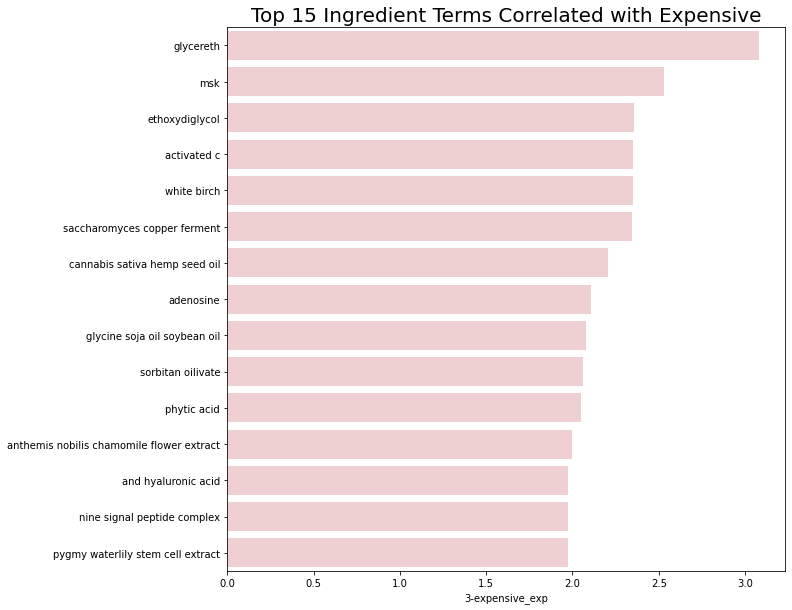

In [260]:
# Plot top ingredients correlated with '3-expensive'
plt.figure(figsize=(10,10))
sns.barplot(data=top_ingr_expensive_df, x=top_ingr_expensive_df['3-expensive_exp'], y='ingredient_terms', color='#f4cbcdff')
plt.ylabel('')
plt.title('Top 15 Ingredient Terms Correlated with Expensive', fontsize=20)

###  Area Under the Curve (AUC) of Receiver Operating Characteristic (ROC)  

The ROC curve is an evaluation metric for binary classification problems. In order to extend ROC curve to multi-class classification, it is necessary to binarize the output so that each class is represented by one ROC curve. In the **One-Vs-Rest (OvR)** approach that splits the 3-class dataset into one binary dataset for each class, the dataset could be divided into 3 binary clssification datasets as follows:
- Class 1-cheap Vs Rest (2-average and 3-expensive)
- Class 2-average Vs Rest (1-cheap and 3-expensive)
- Class 3-expensive Vs Rest (1-cheap and 2-average)

ROC is a probability curve that plots the True Positive Rate (Y-axis) against False Positive Rate (X-axis) at various threshold values and essentially separates the "signal" from the "noise". The ROC curve is generated by varying our threshold from 0 to 1. This doesn't actually change the threshold or our original predictions, but it helps us to visualize our tradeoff between sensitivity and specificity and understand how well-separated our populations are. The top left corner of the plot is the "ideal" point - a false positive rate of zero, and a true positive rate of one. The "steepness" of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

The AUC is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.

Let's have a look at the AUC-ROC Curves for each class to help us visualize how well our machine learning classifier is performing.

In [261]:
# Source: https://inblog.in/AUC-ROC-score-and-curve-in-multiclass-classification-problems-2ja4jOHb2X

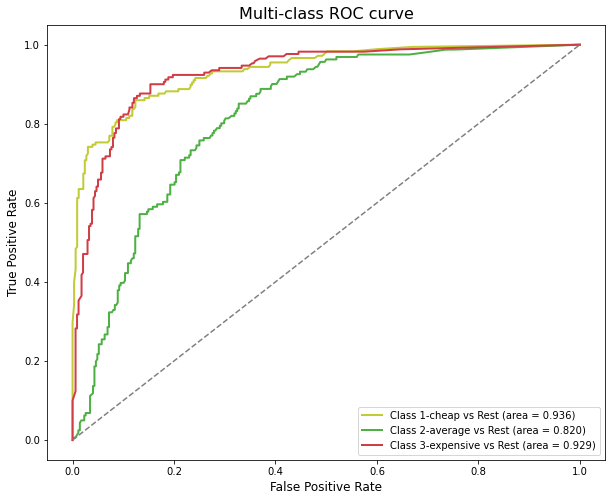

In [262]:
# Plot AUC-ROC Curve using One Vs All technique
# Source: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

n_class = 3

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc ={}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_proba[:,i], pos_label=i+1)
    roc_auc[i] = auc(fpr[i], tpr[i])

    
# Set up the matplotlib figure size
plt.figure(figsize=(10,8))

# Plot ROC  
plt.plot(fpr[0], tpr[0], lw=2, color='#c0cb35ff', label='Class 1-cheap vs Rest (area = {1:0.3f})'.format(0, roc_auc[0]))
plt.plot(fpr[1], tpr[1], lw=2, color='#4db043ff', label='Class 2-average vs Rest (area = {1:0.3f})'.format(1, roc_auc[1]))
plt.plot(fpr[2], tpr[2], lw=2, color='#d03d44ff', label='Class 3-expensive vs Rest (area = {1:0.3f})'.format(2, roc_auc[2]))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color = 'grey', label ='' )
plt.title('Multi-class ROC curve', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.legend(loc='best')


label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i])

The AUC is also computed using the OvR method with two averaging strategies below, where the AUC of each class is computed against the rest of the other classes. ROC AUC currently only handles the 'macro' and 'weighted' averages for multi-class.

- **Macro**: Calculate metrics for each label, and find their unweighted mean. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally). For  imbalance dataset, this is not a good option as it is  assigns equal weights to the score calculated for each label. The label with higher percentage may dominate the label with very lower percentage. 

- **Weighted**: Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).

In [263]:
# Compute ROC AUC scores
# Source: https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics
macro_roc_auc_ovr = roc_auc_score(y_test,  tvec_lr_gs.predict_proba(X_test), multi_class='ovr', average='macro')
weighted_roc_auc_ovr = roc_auc_score(y_test,  tvec_lr_gs.predict_proba(X_test), multi_class='ovr', average='weighted')
print('One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} '
    '(weighted by prevalence)'.format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-Rest ROC AUC scores:
0.895643 (macro),
0.897585 (weighted by prevalence)


We can see that our selected model is performing better at distinguishing between the positive and negative classes for Class 1-cheap and Class 3-expensive, as compared to Class 2-average. This is indicated by their respective macro AUC scores, which are close to 1. The classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives for Class 1-cheap and Class 3-expensive. 

# 8. Insights & Conclusion

## 8.1. Summary

The following summarizes our results and insights:


**1) Identified determinants of product price**
- The 3-class logistic regression model (with TfidfVectorizer) revealed pricing patterns in the skincare products with it being able to predict price categories with an accuracy of 74.5%. 
- There are specific brands that are strong predictors of price for each class.
- Product category is more important in predicting cheaper products.
- Products with ingredients that are non-toxic or have anti-aging properties are more expensive.

**2) Analysed product ingredients**
- Plant-based ingredients are associated with average- expensive products.
- Cheaper products have more alcohol derivatives, which are known to be more harmful and drying to the skin. 

**3) Created a simple recommender system based on product ingredient similarity**
- Able to query for a product that is similar to a selected product.
- Able to compare similarity of two products.
- Possibility of using the recommender to surface cheaper alternatives of similar products.

## 8.2. Limitations and Future Considerations


- In establishing product similarity, the proportion of ingredients is also an important factor as the concentration can change the product’s effectiveness/ similarity. However, this level of detail is not publicly available and is considered out-of-scope for this project.

- Generalisability may be limited as only products available on Sephora US are covered. There is little coverage for Asian skincare products, which may contain other types of common ingredients like  snail mucin and ginseng. One future consideration would be to include products from Asia and other continents in the analysis. 

- Collaboration with cosmetic chemists could facilitate better analysis on the effectiveness of the ingredients. 